## Preamble/setup

In [22]:
import os
import shutil
import time
import cv2
import random
import json
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from fractions import Fraction
import colorsys

import torch
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, Subset, RandomSampler, DataLoader, ConcatDataset

import utils

In [23]:
# Option for whether to only plot the results from saved scores, or to recalculate from scratch.
# Note this is very slow, but allows reproduction of all results
recalculate_results = False

plot_titles = False
save_plots = True
if save_plots:
    if not os.path.exists('Images'):
        os.makedirs('Images')

In [24]:
device_name = utils.get_device()
device = torch.device(device_name)
CNN_params_dict = utils.CNN_params_setup(device)
dropout_conv, dropout_fc = CNN_params_dict['dropout_conv'], CNN_params_dict['dropout_fc']

In [25]:
## Plotting parameters for uniformity
my_fig_size = (7,6) # figure size
ms = 10 # marker size
lw = 4 # line width
title_size = 19.5
label_size = 22
legend_size = 19
tick_size = 17

grid_params = {'which':'both', 'linestyle':'--', 'color':'gray', 'alpha':0.45}
def plot_baseline(label=None, ax=None):
    line_args = {'y': 1, 'ls': "-", 'lw': 0.6, 'color': 'dimgray', 'alpha': 1}
    if label:
        line_args['label'] = label
    if ax:
        ax.axhline(**line_args)
    else:
        plt.axhline(**line_args)

font_name = "Times New Roman"
plt.rcParams["font.family"] = font_name
# Set global font family for LaTeX math text
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = font_name  # Replace font_name with your desired font
mpl.rcParams['mathtext.it'] = font_name
mpl.rcParams['mathtext.bf'] = font_name


## Original data CNN learning curve

In [26]:
# if recalculate_results: 
# Load the CIFAR-10 data to memory
full_cifar_dataset = CIFAR10
# Define data transformations
transform = transforms.Compose([transforms.ToTensor(),]) # Convert PIL Image to PyTorch Tensor

train_dataset = full_cifar_dataset(
    root=f'./{"data/cifar-10-orig"}',  # Change the root directory as needed
    train=True,      # Set to True for the training set
    transform=transform,
    download=True)

test_dataset = full_cifar_dataset(
    root=f'./{"data/cifar-10-orig"}',  # Change the root directory as needed
    train=False,     # Set to False for the test set
    transform=transform,
    download=True)

Files already downloaded and verified
Files already downloaded and verified


In [27]:
# Setup our main n_orig = 1024 sample
N = 1024

seed = 42
random.seed(seed)

random_indices = random.sample(range(len(train_dataset)), N)
train_samp = Subset(train_dataset, random_indices)
# Separate the images and labels
images_samp = torch.stack([train_samp[i][0] for i in range(N)])  # Stack the image tensors
labels_samp = torch.tensor([train_samp[i][1] for i in range(N)])  # Convert labels to a tensor

# Return as TensorDataset
subset_train_dataset = TensorDataset(images_samp, labels_samp)

### Baseline classification accuracy

In [28]:
# takes about 1 min per repeat to run (on my gpu)
if recalculate_results:
    repeats = 25
    baseline_scores_list = []
    for i in range(repeats):
        print(f"Calculating baseline scores, repeat {i + 1} of {repeats}")
        baseline_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)

        _, _, test_score = utils.nn_trainer(baseline_model, subset_train_dataset, test_dataset, opt_type = "adam", 
                CNN_params_dict = CNN_params_dict, loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False)
        
        baseline_scores_list += [test_score]  
        end_time = time.time()

    avg_baseline_accuracy = np.mean(baseline_scores_list)
    print(f"Baseline classification accuracy: {avg_baseline_accuracy}")
else:
    avg_baseline_accuracy = 0.42261 # score hard-coded from full run (easier than saving to a separate file)

In [29]:
# takes about 6 hours to run on my gpu
orig_lc_json_name = "scores/orig_data_learning_curve.json"

if recalculate_results:
    n_samp = [100, 200, 500, 1000, 2000, 4000, 8000, 15000, 30000, 50000]
    epoch_list = [20, 30, 50, 70, 100]
    lc_orig_dict = {}

    for j, e in enumerate(epoch_list):
        lc_orig_dict[f"Epochs = {e}"] = {}
        lc_CNN_params_dict = CNN_params_dict
        lc_CNN_params_dict['epochs'] = e
        for i in range(len(n_samp)):
            start_time = time.time()

            n = n_samp[i]
            random_indices = random.sample(range(len(train_dataset)), n)
            lc_train_samp = Subset(train_dataset, random_indices)
            # Separate the images and labels
            images = torch.stack([lc_train_samp[i][0] for i in range(n)])  # Stack the image tensors
            labels = torch.tensor([lc_train_samp[i][1] for i in range(n)])  # Convert labels to a tensor

            # Return as TensorDataset
            lc_subset_train_dataset = TensorDataset(images, labels)

            lc_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)

            _, _, test_score = utils.nn_trainer(lc_model, lc_subset_train_dataset, test_dataset, opt_type = "adam", 
                    CNN_params_dict=lc_CNN_params_dict, loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False)
            
            lc_orig_dict[f"Epochs = {e}"][n] = test_score  
            end_time = time.time()
            print(f"Run {i + 1} out of {len(n_samp)} samples and {j+1} out of {len(epoch_list)} epochs, for {n} samples and {e} epochs. Test score = {round(test_score, 3)}. Runtime = {round(end_time - start_time, 1)} seconds")
            
    with open(orig_lc_json_name, 'w') as json_file:
        json.dump(lc_orig_dict, json_file)
else:
    with open(orig_lc_json_name, 'r') as json_file:
            lc_orig_dict = json.load(json_file)

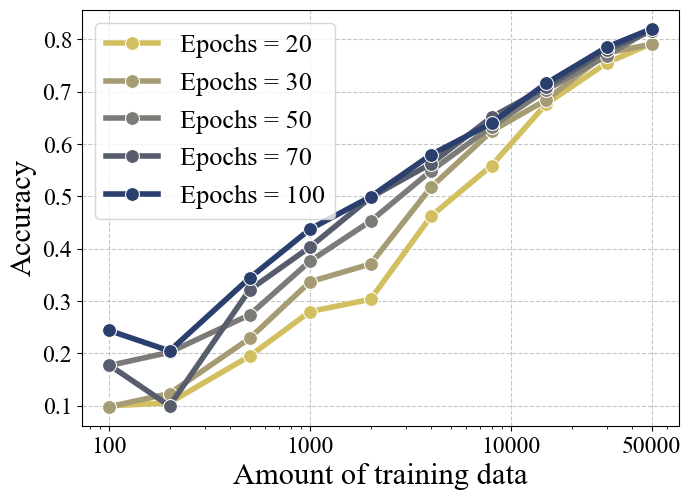

In [30]:
lc_orig_plotname = "Images/cnn_learning_curve.pdf"
# Prepare the data for seaborn
data_list = []
for epochs, data in lc_orig_dict.items():
    for amount, accuracy in data.items():
        data_list.append({'Epochs': epochs, 'Amount': int(amount), 'Accuracy': accuracy})

df = pd.DataFrame(data_list)

# Create the plot
fig, ax = plt.subplots(figsize=(my_fig_size[0]*1.1, my_fig_size[1]*0.9))
sns.lineplot(data=df, x='Amount', y='Accuracy', hue='Epochs', marker='o', markersize = ms, linewidth = lw, palette='cividis_r')

# Set log scale for x-axis
plt.xscale('log')

plt.xlabel("Amount of training data", fontsize=label_size)
plt.ylabel("Accuracy", fontsize=label_size)
# plt.title("Learning curve for varying epochs", fontsize=title_size)
xticks = [100, 1000, 10000, 50000]
plt.xticks(xticks, labels=[str(x) for x in xticks], fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.legend(fontsize=legend_size)
plt.grid(True, **grid_params)
plt.grid(False, which='minor')  # Disable gridlines for minor ticks

if save_plots:
    plt.savefig(lc_orig_plotname, format="pdf", bbox_inches="tight")

plt.show()

## Conventional transformation image samples

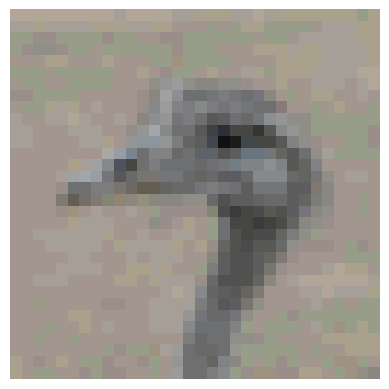

In [31]:
test_img = cv2.imread('data/bird_example.png')
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(test_img)
plt.axis('off')
plt.show()

/var/folders/fp/xm4cc_hs2tqbkld8167bbm280000gq/T/ipykernel_2232/3743374848.py:25: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3618.)
  img = utils.img_transformation(torch.tensor(test_img).T, prob = 1, gamma = gamma, seed = (53 + (i * j))).T


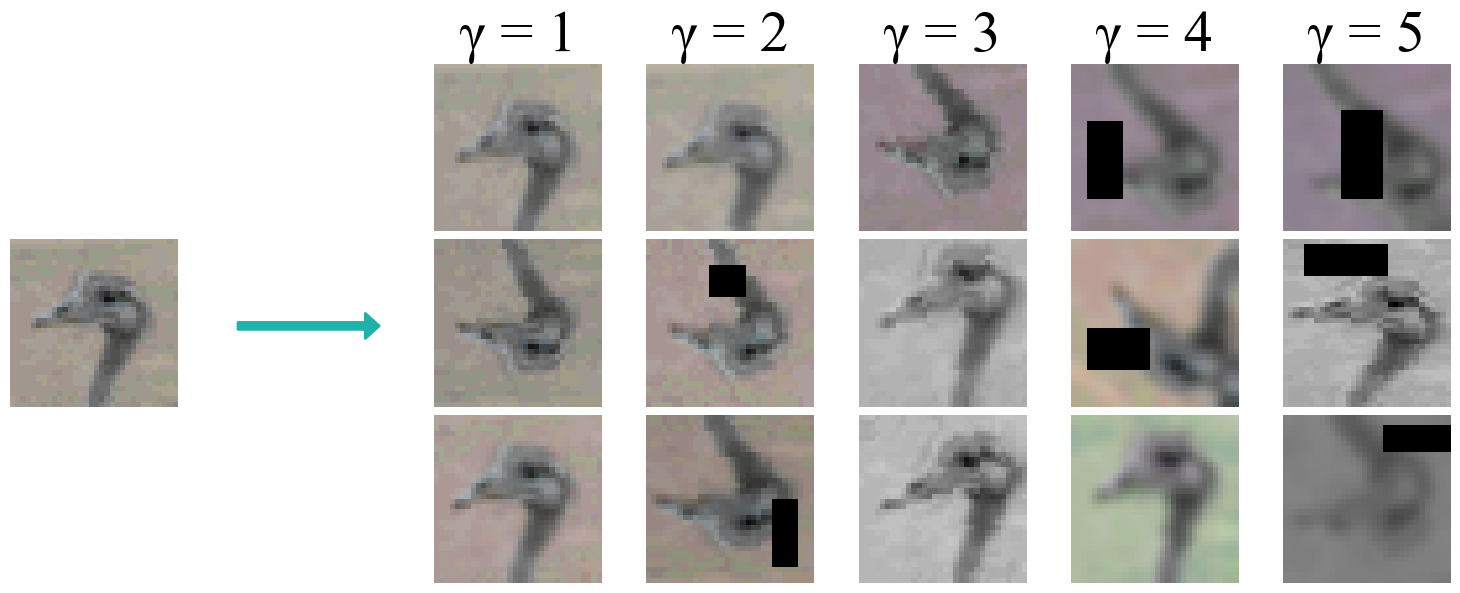

In [32]:
aug_birds_plotname = "Images/aug_birds.pdf"

### Standard
nrow = 3
ncol = 7
fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
plt.subplots_adjust(hspace=-0.61, wspace=-0.4)
for i in range(nrow):
    for j in range(ncol):
        ax = axes[i, j]
        if j == 0:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            if i == 1:
                ax.imshow(test_img)
            ax.axis('off')
        elif j == 1:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            if i == 1:
                ax.annotate('', xy=(30, 16), xytext=(2, 16),
            arrowprops=dict(arrowstyle="Simple,tail_width=0.5,head_width=1.8,head_length=1",
                            lw=2, color='lightseagreen'))
            ax.axis('off')
        elif j >= 2:
            gamma = j - 1
            img = utils.img_transformation(torch.tensor(test_img).T, prob = 1, gamma = gamma, seed = (53 + (i * j))).T
            ax.imshow(img)
            if i == 0:
                ax.set_title(f"γ = {gamma}", fontsize=42) 
            ax.axis('off')
fig.tight_layout()

if save_plots:
    plt.savefig(aug_birds_plotname, format="pdf", bbox_inches="tight")

plt.show()

## Conventional transformation optimisation
### Accuracy vs intensity gamma

In [33]:
acc_conv_gamma_json_name = "scores/acc_vs_conv_gamma.json"

if recalculate_results:
    gamma_list = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]
    alpha_list = [1.01, 1.5, 2.5, 4, 6, 10]

    test_accs_per_alpha_dict = {}
    repeats = 5
    real_accs_per_aug_ratio = {}
    for ind, alpha in enumerate(alpha_list):
        test_acc_repeats = []
        for i in range(repeats):
            start_time = time.time()
            i_test_acc_list = []

            for gamma in gamma_list:    
                cnn_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, test_score = utils.nn_trainer(cnn_model, subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                    loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                    augmentation = True, aug_ratio = alpha, aug_var = gamma)
                i_test_acc_list += [test_score]
            test_acc_repeats += [i_test_acc_list]
            end_time = time.time()
            print(f"Run for alpha number {ind+1} out of {len(alpha_list)} ({alpha}) and repeat {i+1} of {repeats} complete (note each run tests {len(gamma_list)} gamma options). Runtime = {round(end_time - start_time, 1)} seconds")

        test_accs_per_alpha_dict[alpha] = test_acc_repeats
            
    with open(acc_conv_gamma_json_name, 'w') as json_file:
        json.dump(test_accs_per_alpha_dict, json_file)
else:
    with open(acc_conv_gamma_json_name, 'r') as json_file:
            test_accs_per_alpha_dict = json.load(json_file)

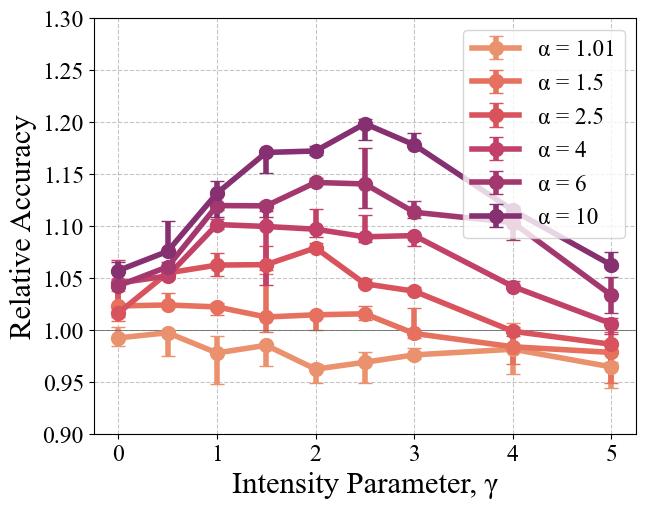

In [34]:
conv_acc_vs_gamma_plotname = "Images/acc_vs_gamma.pdf" 

# x_axis = [-1] + var_list
alpha_list = list(test_accs_per_alpha_dict.keys())
gamma_list = [0, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5]

# Prepare the data for seaborn
data_list = []
for alpha in alpha_list:
    this_accs = np.array(test_accs_per_alpha_dict[alpha])
    lq, med, uq = np.percentile(this_accs / avg_baseline_accuracy, [25, 50, 75], axis=0)
    lqd, uqd = med - lq, uq - med

    data_list.append({
        'Augmentation Ratio': alpha,
        'x': gamma_list,
        'Median Accuracy': med,
        'Lower Deviation': lqd,
        'Upper Deviation': uqd
    })

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data_list)

# Create the plot
plt.figure(figsize=(my_fig_size[0], my_fig_size[1]*0.9))
palette = sns.color_palette('flare', len(alpha_list)+1)

# Plot each augmentation ratio
for i, alpha in enumerate(alpha_list):
    plt.errorbar(df.loc[i, 'x'], df.loc[i, 'Median Accuracy'], 
                 yerr=[df.loc[i, 'Lower Deviation'], df.loc[i, 'Upper Deviation']], 
                 fmt='o-', label=f"α = {alpha}", capsize=5, color=palette[i], 
                 markersize = ms, linewidth = lw)

plt.ylim(0.9, 1.3)
plt.legend(fontsize=0.88*legend_size)
plt.xlabel("Intensity Parameter, γ", fontsize=label_size)
plt.ylabel("Relative Accuracy", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)

# plt.axhline(y=1, color='gray', linestyle='--', lw = 2.5)
plot_baseline()

plt.grid(True, **grid_params)
if plot_titles:
    plt.title("Relative Accuracy vs γ", fontsize=title_size)

if save_plots:
    plt.savefig(conv_acc_vs_gamma_plotname, format="pdf", bbox_inches="tight")

plt.show()

In [35]:
gamma = 3

### Accuracy vs ratio alpha

In [36]:
gamma = 3
alphas = [1.5, 2.5, 5, 7, 10, 13, 16, 20, 25, 30, 35, 40, 50]
acc_conv_alpha_json_name = "scores/acc_vs_conv_alpha.json"

if recalculate_results:
    acc_aug_dict = {}
    N = 5
    for j in range(N):
        t0 = time.time()
        acc_per_rep_list = []
        for i, alpha in enumerate(alphas):
            print(f"Calculating scores for rep {j+1} of {N}, and alpha {i+1} of {len(alphas)}")
            ti = time.time()
            print(f"Calculating for alpha {i+1} out of {len(alphas)} ({alpha}), repeat {j+1} of {N}. Time so far = {round((ti-t0)/60, 1)} minutes.")
            cnn_mod = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
            _, _, test_acc = utils.nn_trainer(cnn_model, subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                    loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                    augmentation = True, aug_ratio = alpha, aug_var = gamma)
            acc_per_rep_list += [test_acc]
        acc_aug_dict[j] = acc_per_rep_list


    # Save the output dictionary to json file
    with open(acc_conv_alpha_json_name, 'w') as json_file:
        json.dump(acc_aug_dict, json_file)
else:
    with open(acc_conv_alpha_json_name, 'r') as json_file:
            acc_aug_dict = json.load(json_file)

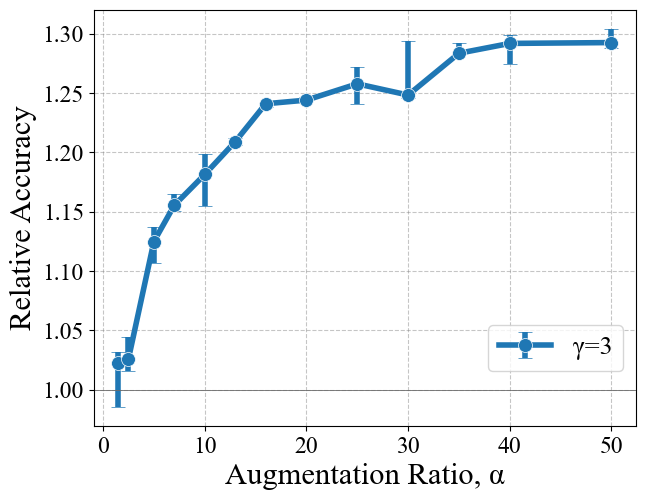

In [37]:
conv_acc_vs_alpha_plotname = "Images/acc_vs_alpha.pdf"

alphas = [1.5, 2.5, 5, 7, 10, 13, 16, 20, 25, 30, 35, 40, 50]
alpha_arr = np.array(list(acc_aug_dict.values()))
lq, med, uq = np.percentile(alpha_arr / avg_baseline_accuracy, [25, 50, 75], axis=0)
lqd, uqd = med - lq, uq - med

plt.figure(figsize=(my_fig_size[0], my_fig_size[1]*0.9))

plt.errorbar(alphas, med, yerr=[lqd, uqd], fmt='o-', capsize=5, 
            markersize = ms, linewidth = lw, label="γ=3",
            markeredgecolor='white', markeredgewidth=0.5, )

plt.ylabel("Relative Accuracy", fontsize=label_size)
plt.xlabel("Augmentation Ratio, α", fontsize=label_size)

plt.xticks(fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.legend(fontsize=legend_size, loc="lower right", bbox_to_anchor=(1, 0.1))

plot_baseline()

if plot_titles:
    plt.title("Relative Accuracy vs α", fontsize=title_size)
# plt.annotate(f"Error bars showing median & IQR across {len(acc_aug_dict)} tests", 
#              xy=(0.5, 0.97), xycoords='axes fraction', 
#              fontsize=10, ha='center', va='center')
plt.grid(True, **grid_params)

if save_plots:
    plt.savefig(conv_acc_vs_alpha_plotname, format="pdf", bbox_inches="tight")

plt.show()

### Learning curve on full data with augmentation

In [38]:
gamma = 2.5
alphas = [None, 2, 5, 20, 50]
n_samp = [100, 200, 500, 1024, 2000, 4000, 8000, 15000, 30000, 50000]

aug_lc_dict_json_name = "scores/aug_acc_lc.json"

if recalculate_results:
    train_length = len(train_dataset)
    seed = 42
    random.seed(seed)
    aug_lc_dict = {}
    # Loop through the alphas (amount of augmented data to use)
    for j, alpha in enumerate(alphas):
        # Set up name and aug_lc_dict for this iteration depending on augmentation type
        aug_bool = alpha is not None
        if aug_bool:
            score_name = f"alpha = {alpha}"
        else:
            score_name = "No augmentation"
        aug_lc_dict[score_name] = {}

        # Loop through the data sample lengths
        for i, n in enumerate(n_samp):
            # Time the code
            start_time = time.time()
            
            # Sample the cifar data n times (n being the current number of samples for this iteration) without replacement
            random_indices = random.sample(range(train_length), n)
            # Organise into a dataset
            random_reals = [train_dataset[i] for i in random_indices]
            random_x, random_y = zip(*random_reals)  # Unzip data into separate lists
            lc_subset_train_dataset = TensorDataset(torch.stack(random_x), torch.tensor(random_y))
            
            cnn_mod = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
            _, _, test_acc = utils.nn_trainer(cnn_mod, lc_subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                        loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                        augmentation = aug_bool, aug_ratio = alpha, aug_var = gamma)
            aug_lc_dict[score_name][n] = test_acc  
            end_time = time.time()
            print(f"Run {(i+1) + (j)*(len(n_samp))} out of {len(n_samp) * len(alphas)} complete, for {n} samples and {score_name}. Test score = {round(test_acc, 3)}. Runtime = {round(end_time - start_time, 1)} seconds")

    # Save the output dictionary to json file
    with open(aug_lc_dict_json_name, 'w') as json_file:
        json.dump(aug_lc_dict, json_file)
else:
    with open(aug_lc_dict_json_name, 'r') as json_file:
        aug_lc_dict = json.load(json_file)

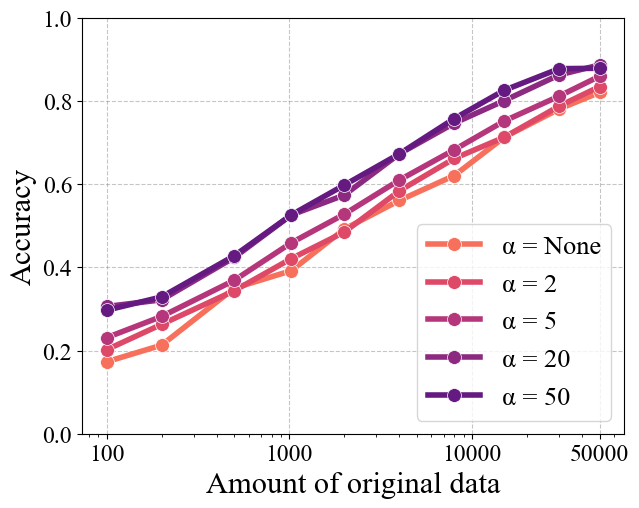

In [39]:
conv_lc_plotname = "Images/aug_learning_curve.pdf"

# Convert JSON dictionary to DataFrame
lc_df = pd.DataFrame(aug_lc_dict)
lc_df.reset_index(inplace=True)
lc_df.rename(columns={"index": "n_real"}, inplace=True)
lc_df["n_real"] = lc_df["n_real"].astype(int)
lc_df = lc_df.set_index("n_real")

# Create the plot
plt.figure(figsize=(my_fig_size[0], my_fig_size[1]*0.9))

num_columns = len(lc_df.columns)
palette = sns.color_palette('magma_r', num_columns+4)

# Plot each column with a distinct color
for i, column in enumerate(lc_df.columns):
    # legend_entry = column.replace('α', '$α_c$')
    plt.semilogx(lc_df.index, lc_df[column], label=column, 
                 marker='o', color=palette[i+2], markersize=10, 
                 linewidth=4, markeredgecolor='white', markeredgewidth=0.5)

# Aesthetics
plt.xlabel("Amount of original data", fontsize=label_size)
plt.ylabel("Accuracy", fontsize=label_size)
plt.legend(fontsize=legend_size)
xticks = [100, 1000, 10000, 50000]
plt.xticks(xticks, labels=[str(x) for x in xticks], fontsize=tick_size)
plt.yticks(fontsize=tick_size)
plt.ylim(0, 1)  # Set Y limits if needed
plt.grid(True, **grid_params)
plt.grid(False, which='minor')  # Disable gridlines for minor ticks

if plot_titles:
    plt.title("Learning curve for different augmentation ratios", fontsize=title_size)

if save_plots:
    plt.savefig(conv_lc_plotname, format="pdf", bbox_inches="tight")

plt.show()


## ImageGPT
### output samples

In [40]:
rep_sizes = [3]
prompt_sizes = {"small":0.25, "med":0.5, "large":0.75}
feature_extractor, model, clusters, device = utils.igpt_model_setup(device_name="cpu")

real_img = train_dataset[2993][0]

This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (1024). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.


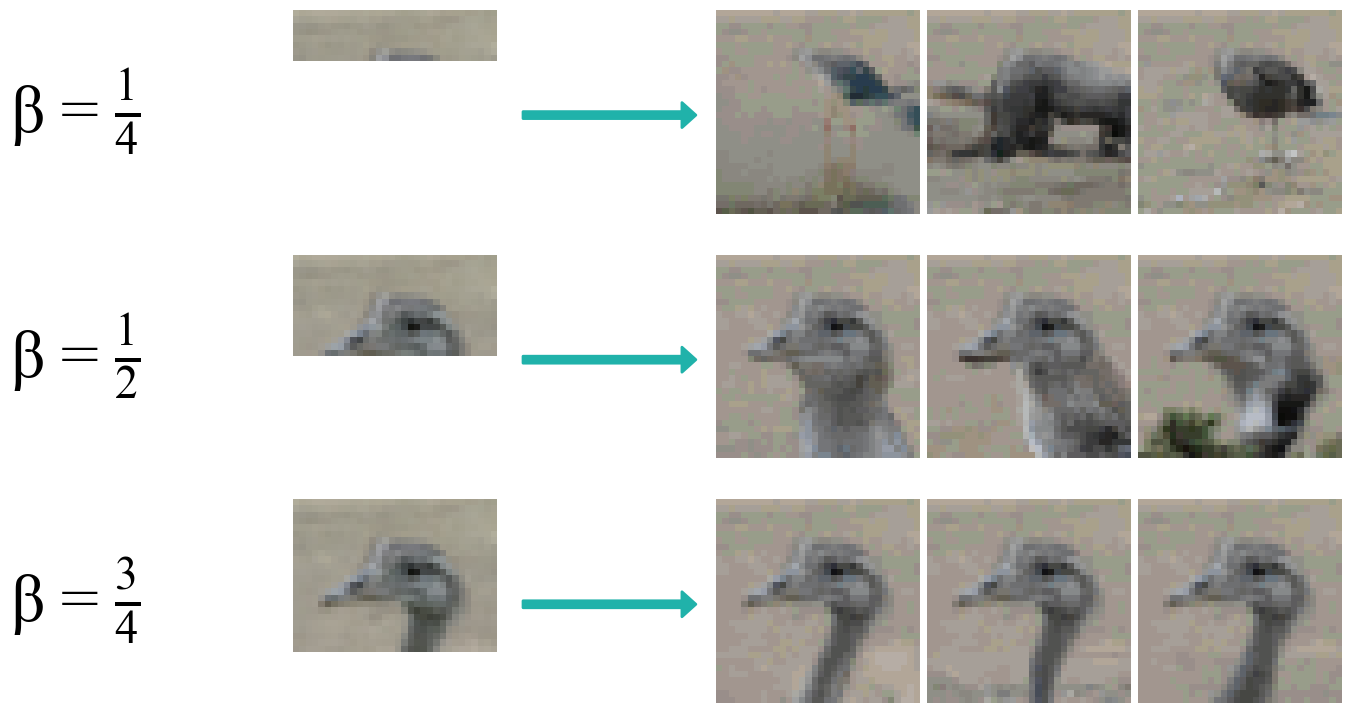

In [41]:
demo_igpt_bird_plotname = "Images/igpt_example_birds.pdf"

seed = 10

all_syn_imgs = utils.create_igpt_img(real_img, 32, feature_extractor, clusters, model, device, rep_sizes, prompt_sizes, return_img_dict = True, gen_seed = seed)
# Calculate the number of rows and columns
num_rows = len(all_syn_imgs)
num_cols = 5
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 3*num_rows))
plt.subplots_adjust(hspace=0.2, wspace=-0.7)

for i, (syn_set, item) in enumerate(all_syn_imgs.items()):
    for j in range(num_cols):
        ax = axes[i, j]
        if j == 0:
            if "small" in syn_set:
                frac = 0.25
            elif "med" in syn_set:
                frac = 0.5
            elif "large" in syn_set:
                frac = 0.75

            # Generate the white pixels
            white_pixels = torch.ones_like(real_img[:, :int((1 - frac) * 32), :])
            # Concatenate white pixels to the bottom of the original image
            extended_img = torch.cat([real_img[:, :int(frac * 32), :], white_pixels], dim=1)
            # Plot the extended image in the first column
            ax.imshow(extended_img.permute(1, 2, 0), aspect='equal')
            ax.axis('off')
            frac_str = fr"$\frac{{{Fraction(frac).limit_denominator().numerator}}}{{{Fraction(frac).limit_denominator().denominator}}}$"
            ax.text(-0.75, 0.5, f"β = {frac_str}", transform=ax.transAxes, rotation='horizontal',
                    verticalalignment='center', horizontalalignment='right', fontsize=48, color='black')
            # ax.text(-0.18, 0.5, "prompt", transform=ax.transAxes, rotation='horizontal',
            #         verticalalignment='center', horizontalalignment='right', fontsize=20, color='black')
        # Plot the white image with an arrow in the second column
        elif j == 1:
            ax.imshow(np.ones((32, 32, 3)))  # White image
            ax.annotate('', xy=(30, 16), xytext=(2, 16),
                arrowprops=dict(arrowstyle="Simple,tail_width=0.5,head_width=1.8,head_length=1",
                            lw=2, color='lightseagreen'))
            ax.axis('off')
        # Plot the three images from the item list in columns 3, 4, and 5
        else:
            ax.imshow(item[j - 2].transpose(1, 2, 0))
            ax.axis('off')

if save_plots:
    plt.savefig(demo_igpt_bird_plotname, format="pdf", bbox_inches="tight")

plt.show()

### Generator our ImageGPT datasets

In [42]:
if recalculate_results:
    import subprocess
    seed_list = "42,43,44,45,46,47"
    command = [ ### doing this avoids annoying pylance errors
        "python", "igpt_generator.py",
        "--out_path=data/igpt_syn_data/individual_imgs",
        "--h5_path=data/igpt_syn_data/cifar_sample_data_train",
        "--multi=True",
        "--rep=2,4,6,8",
        "--prompt=small,med,large",
        "--samples=64",
        f"--device={device_name}",
        "--save=True",
        f"--seed_list={seed_list}"
    ]
    subprocess.run(command)


## GAN output samples

### Train the GANs

In [43]:
# ### need to do these GANs 1, 3, 6, 7
# parent_path = "data/paper_cifar_gan_aug_ratio_15.6/"
# parent_path = "data/paper_cifar_gan_aug_ratio_18.0_aug_var_1.8/"
# parent_path = "data/paper_cifar_gan_aug_ratio_10.0_aug_var_1/"
# parent_path = "data/paper_cifar_gan_aug_ratio_10.0_aug_var_0/"

In [44]:
# GAN option 1
# From Bayesian optimisation:
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.407,
        'gan_epochs': 791,
        'p_drop_disc': 0.453,
        'lr_gen': 2.64e-05,
        'lr_disc': 2.42e-05,
        'gan_aug_ratio': 15.6,
        'gan_aug_var': 0.0,
        'device_name': 'cuda',
        'save_name' : "models/gan_1"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [45]:
# GAN option 2
# From Bayesian optimisation:
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.68,
        'gan_epochs': 500,
        'p_drop_disc': 0.4,
        'lr_gen': 3e-5,
        'lr_disc': 3e-4,
        'gan_aug_ratio': 18,
        'gan_aug_var': 1.8, ####0
        'device_name': 'cuda',
        'save_name' : "models/gan_2"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [46]:
# GAN Option 3
# From manual search
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.25,
        'gan_epochs': 400,
        'p_drop_disc': 0.25,
        'lr_gen': 0.00005,
        'lr_disc': 0.00005,
        'gan_aug_ratio': 10,
        'gan_aug_var': 1,
        'device_name': 'cuda',
        'save_name' : "models/gan_3"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [47]:
# GAN Option 4
# From manual search
if recalculate_results:
    opt_gan_params = {
        'dropout_conv': 0.25,
        'gan_epochs': 400,
        'p_drop_disc': 0.25,
        'lr_gen': 0.00005,
        'lr_disc': 0.00005,
        'gan_aug_ratio': 10,
        'gan_aug_var': 0,
        'device_name': 'cuda',
        'save_name' : "models/gan_4"}

    other_params = {'device_name' : "mps", 'beta_1' : 0.5, 'beta_2' : 0.999999, 'gan_wd' : 0.0015, 'input_size' : 150,
                        'n_layers_gen' : 5, 'n_layers_disc' : 5, 'label_smoothing' : 0, 'disc_noise_std' : 0, 
                        'gan_val_split' : 0, 'gan_batch_size' : 64, 'loader_num_workers' : 0, 'test_reps' : 5}

    !python train_cifar_gan.py --dataset_name cifar10 --out_path {opt_gan_params['save_name']}      --save_type final  --samples 1024 --split_before_samp False      --epochs {opt_gan_params['gan_epochs']} \
        --lr_gen {opt_gan_params['lr_gen']}           --lr_disc {opt_gan_params['lr_disc']}         --beta_1 {other_params['beta_1']}             --beta_2 {other_params['beta_2']} \
        --wd {other_params['gan_wd']}                 --input_size {other_params['input_size']}     --n_layers_gen {other_params['n_layers_gen']} --n_layers_disc {other_params['n_layers_disc']} \
        --p_drop {opt_gan_params['p_drop_disc']}      --device_name {other_params['device_name']}   --augmentation True                           --num_workers {other_params['loader_num_workers']} \
        --aug_ratio {opt_gan_params['gan_aug_ratio']} --aug_var {opt_gan_params['gan_aug_var']}     --training_verbosity 0.5 \
        --test_methods class_rel_acc,fid,fid_inf      --test_reps {other_params['test_reps']}

In [48]:
n_classes = 10
cifar10_classes = np.arange(n_classes)
model_version = "final"

label_dict = {0: b'airplane', 1: b'automobile', 2: b'bird', 3: b'cat', 4: b'deer', 5: b'dog', 6: b'frog', 7: b'horse', 8: b'ship', 9: b'truck'} # Output from CIFAR10

In [49]:
### tidying up: convert local saved gan formats into storage efficient for git
if recalculate_results:
    model_path_list = ['models/gan_1', 'models/gan_2', 'models/gan_3', 'models/gan_4']

    if not recalculate_results: # just to tidy up some parameters for the plotting
        other_params = {'input_size' : 150, 'n_layers_gen' : 5}

    gen_models = {}
    for i, model_path in enumerate(model_path_list):
        gen_model = {}
        for label in cifar10_classes:

            path_to_model = f"{model_path}/label_{label}/model/dcgan_generator_{model_version}.pth"
            gen_model[label] = torch.load(path_to_model, map_location=device)

        gen_models[i+1] = gen_model

    new_model_path_list = ['models_save_space/gan_1', 'models_save_space/gan_2', 'models_save_space/gan_3', 'models_save_space/gan_4']

    nn_input_size = other_params['input_size']
    nn_n_feat = 64
    nn_n_layers_gen = other_params['n_layers_gen']
    for i, model_path in enumerate(new_model_path_list):
        gen_model = gen_models[i+1]
        for label, model in gen_model.items():
            save_path = f"{model_path}/label_{label}"
            os.makedirs(save_path, exist_ok=True)
            
            # initialise
            net_generator = utils.Generator_v2(input_size = nn_input_size, n_feat = nn_n_feat, n_layers = nn_n_layers_gen).apply(utils.weights_init)
            # load
            net_generator.load_state_dict(model['state_dict'])
            # save
            torch.save(net_generator.state_dict(), f"{save_path}/generator_scripted.pth")
        # and copy across the test scores
        shutil.copy(f"{model_path_list[i]}/test_scores.json", f"{model_path}/test_scores.json")

### Summary scores

models_save_space/gan_1


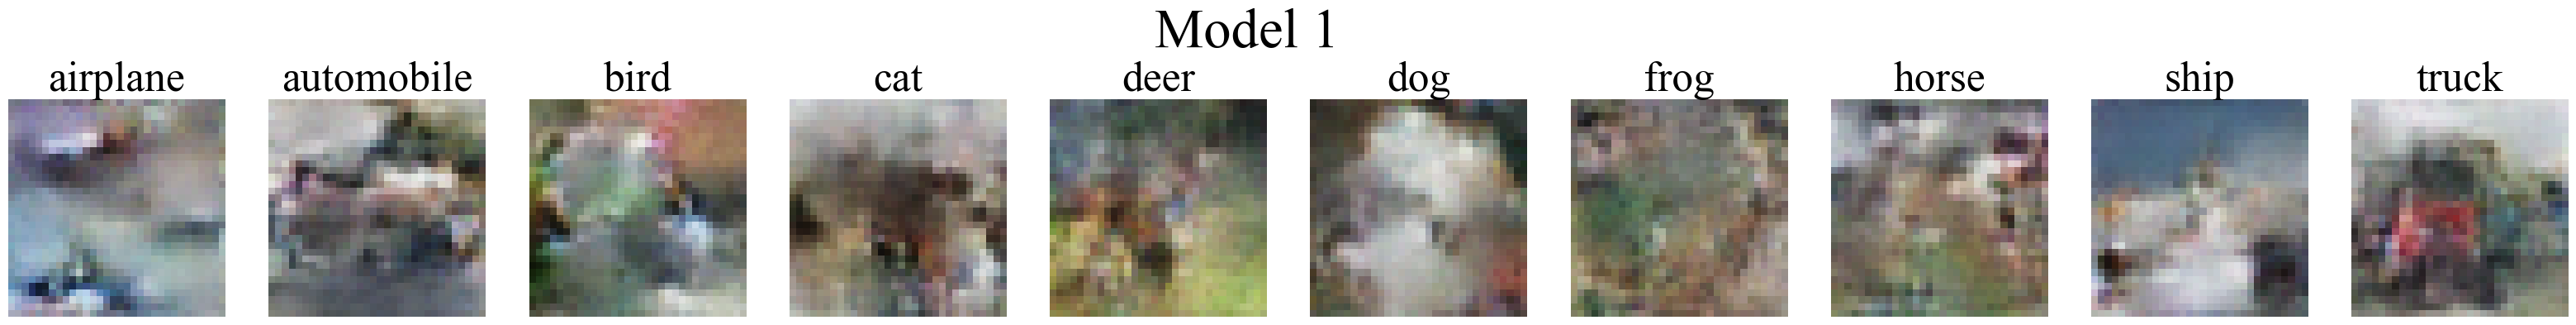

{'class_rel_acc': 1.2142713037114978,
 'fid': 128.692011025412,
 'fid_inf': 116.2814152836751}

models_save_space/gan_2


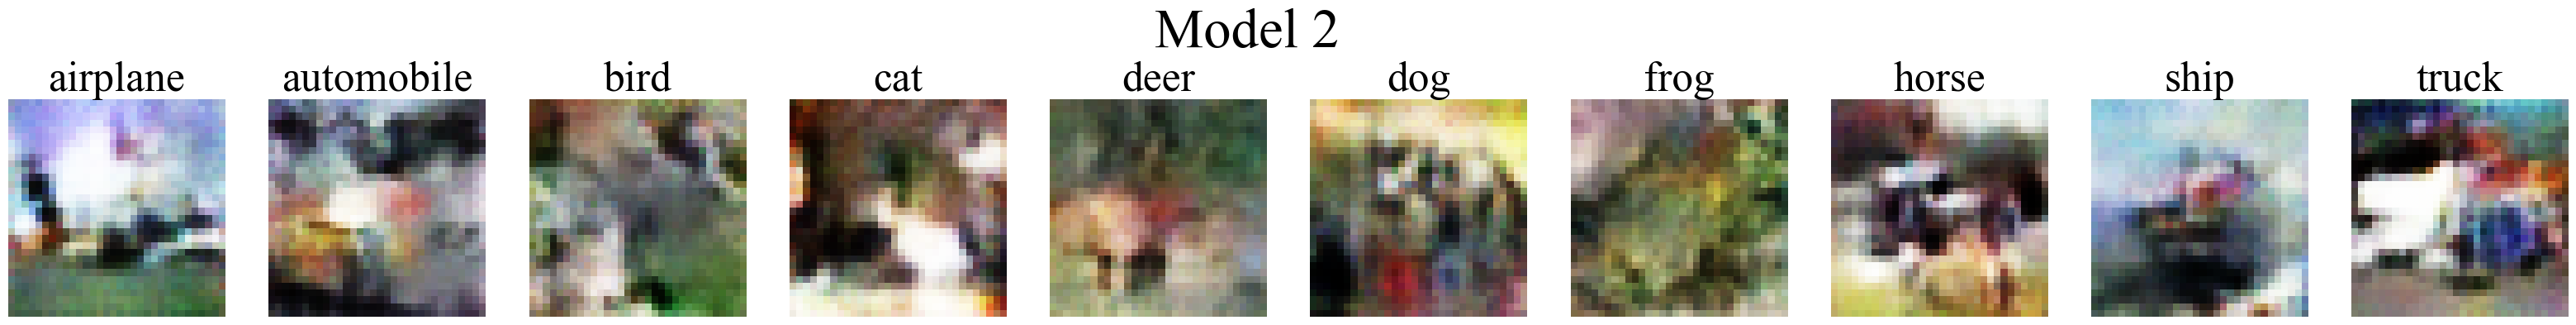

{'class_rel_acc': 1.1426675442334873,
 'fid': 126.22592345019561,
 'fid_inf': 116.60068836149544}

models_save_space/gan_3


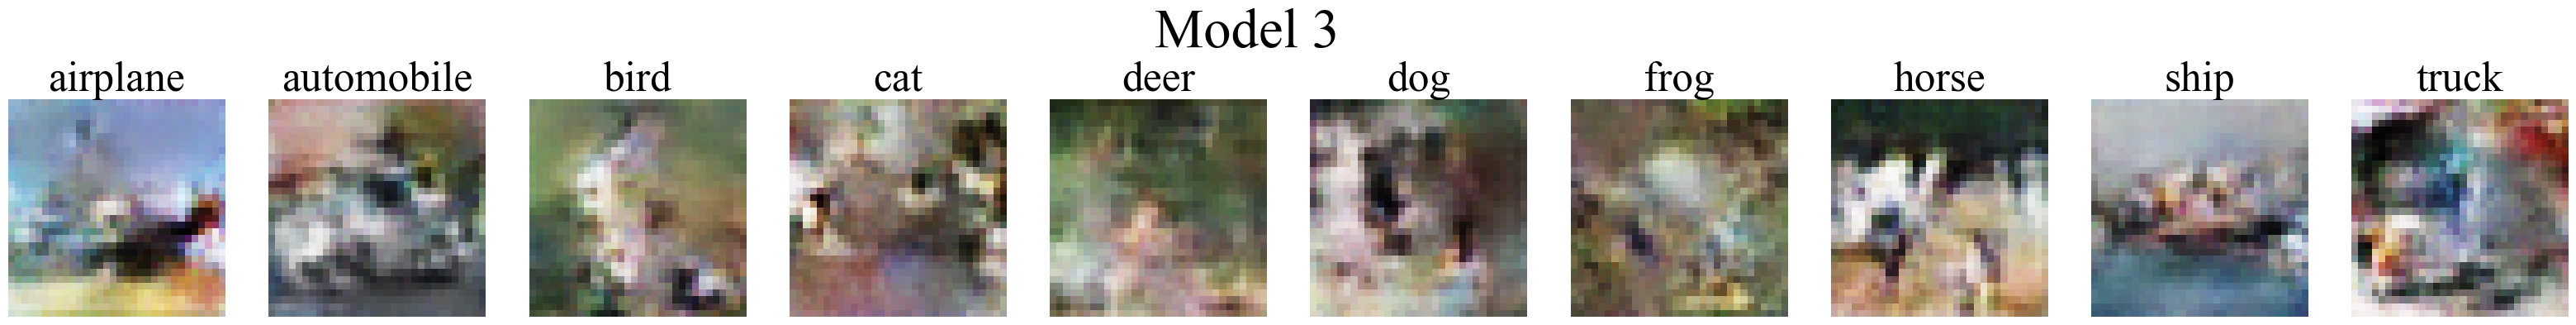

{'class_rel_acc': 1.188031207006298,
 'fid': 124.07119314487609,
 'fid_inf': 114.08027837387976}

models_save_space/gan_4


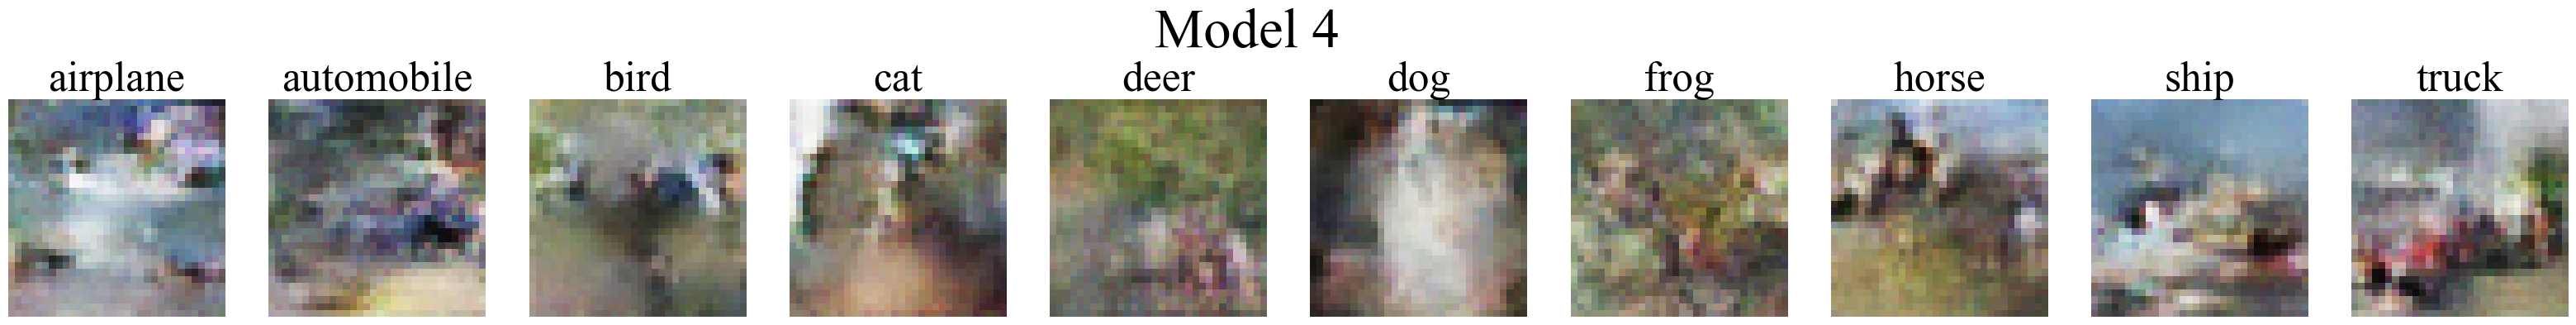

{'class_rel_acc': 1.222566911762803,
 'fid': 162.70908599871453,
 'fid_inf': 152.449967064077}

In [50]:
scripted_models = True # saves space for sharing on git
if scripted_models:
    model_path_list = ['models_save_space/gan_1', 'models_save_space/gan_2', 'models_save_space/gan_3', 'models_save_space/gan_4']
    model_save_type = "scripted"
else:
    model_path_list = ['models/gan_1', 'models/gan_2', 'models/gan_3', 'models/gan_4']
    model_save_type = "state_dict"


if not recalculate_results: # just to tidy up some parameters for the plotting
        other_params = {'input_size' : 150, 'n_layers_gen' : 5}

gen_models = {}
for i, model_path in enumerate(model_path_list):
    gen_model = {}
    for label in cifar10_classes:
        ### Need to do this preamble for the load_model function
        #net_generator = gan_utils.Generator().apply(gan_utils.weights_init)
        #optimizer_generator = optim.Adam(net_generator.parameters(), lr=2e-4, betas=(.5, .999))
        #net_generator, optimizer_generator, epoch = gan_utils.load_model(path_to_model, net_generator, optimizer_generator)
        if scripted_models:
            path_to_model = f"{model_path}/label_{label}/generator_scripted.pth"
            gen_model[label] = torch.load(path_to_model, map_location=device)
            # gen_model[label] = torch.jit.load(path_to_model, map_location=device)

        else:
            path_to_model = f"{model_path}/label_{label}/model/dcgan_generator_{model_version}.pth"
            gen_model[label] = torch.load(path_to_model, map_location=device)

    print(model_path)
    utils.plot_gan_output(gen_model, n_syn = 1, label_dict=label_dict, nn_input_size=other_params['input_size'], model_save_type = model_save_type,
                                nn_n_layers_gen=other_params['n_layers_gen'], model_type="v2", n_classes=n_classes, seed = 42, man_title = f"Model {i+1}")


    test_scores_json_path = f"{model_path}/test_scores.json"
    scores_summary_dict = json.load(open(test_scores_json_path, 'r'))

    this_score = (scores_summary_dict["mean"] if "mean" in scores_summary_dict.keys() else scores_summary_dict)
    display(this_score)

    gen_models[i+1] = gen_model

    # full_scores_set[model_path] = this_score

### Plot the output samples of two top models

Sample output from GAN model 2


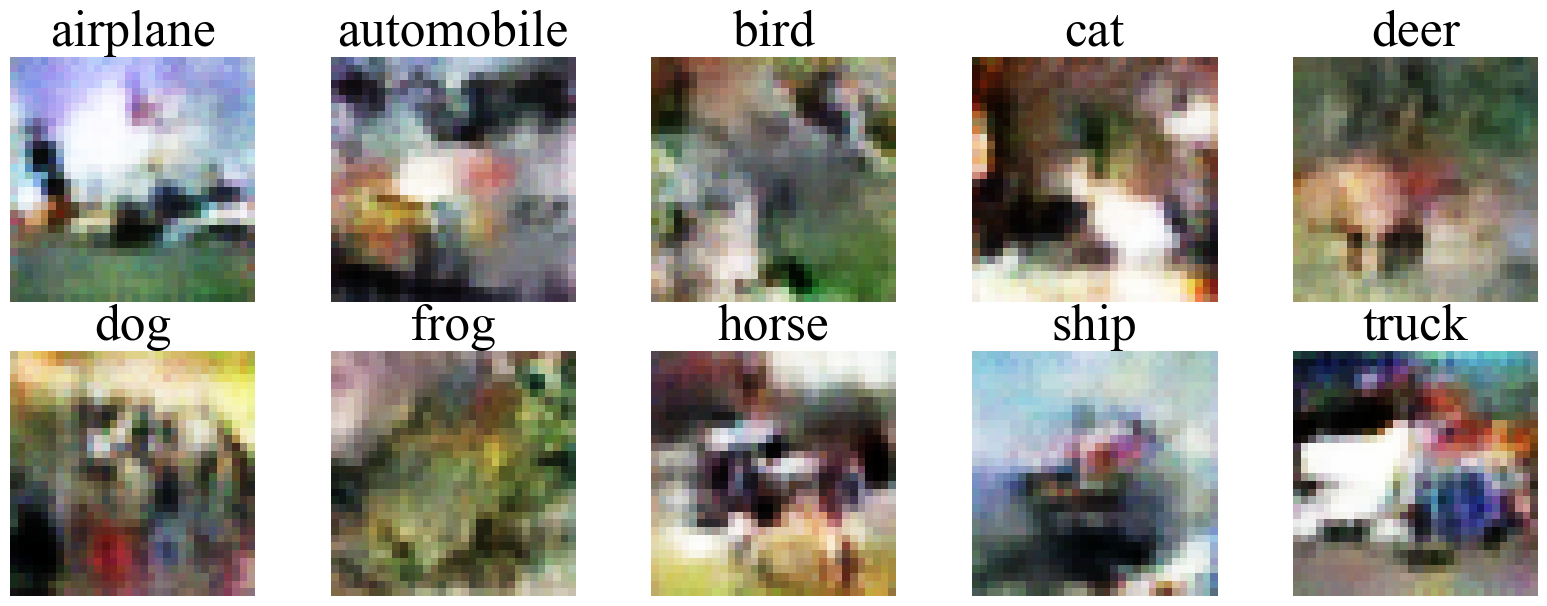

Sample output form GAN model 4


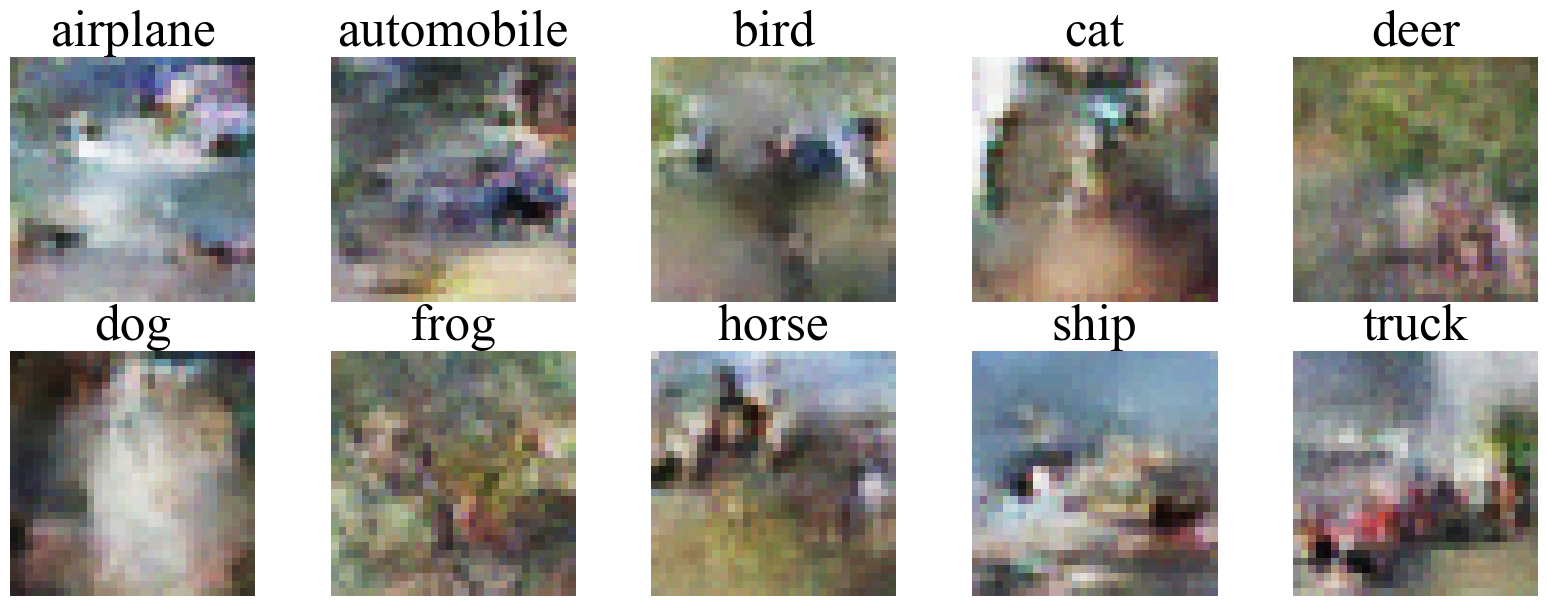

In [51]:
print("Sample output from GAN model 2")
if save_plots:
    gan_2_save_name = "Images/gan_sample_out_2.pdf"
    gan_4_save_name = "Images/gan_sample_out_4.pdf"
else:
    gan_2_save_name = None
    gan_4_save_name = None
utils.plot_gan_output(gen_models[2], n_syn = 1, label_dict=label_dict, nn_input_size=other_params['input_size'], nn_n_layers_gen=other_params['n_layers_gen'], 
    model_type="v2", n_classes=n_classes, seed = 42, man_title = "Sample Output from GAN Model 2", wrap_single = True, 
    model_save_type = model_save_type, plot_titles=plot_titles, save_name=gan_2_save_name)

print("Sample output form GAN model 4")
utils.plot_gan_output(gen_models[4], n_syn = 1, label_dict=label_dict, nn_input_size=other_params['input_size'], nn_n_layers_gen=other_params['n_layers_gen'], 
    model_type="v2", n_classes=n_classes, seed = 42, man_title = "Sample Output from GAN Model 4", wrap_single = True, 
    model_save_type = model_save_type, plot_titles=plot_titles, save_name=gan_4_save_name)

## Accuracy vs FID
### Conventional SD

In [52]:
reps = 5
gammas = [1, 2, 2.5, 3, 4, 5]
alphas = [3, 5, 7, 9]

fid_acc_conv_acc_score_path = "scores/fid_vs_traug_multirun_accs.json"
fid_acc_conv_fid_score_path = "scores/fid_vs_traug_multirun_fids.json"

if recalculate_results:
    all_acc_inds_per_rep = {}
    all_fid_infs_per_rep = {}
    for rep in range(reps):
        t00 = time.time()
        accs_per_var = {}
        fids_per_var = {}
        for j, gamma in enumerate(gammas):
            acc_per_aug = []
            acc_ind_per_aug = []
            fid_inf_per_aug = []
            for i, alpha in enumerate(alphas):

                t0 = time.time()
                print(f"Progress :: Calculating scores for aug var {j+1} of {len(gammas)} and ratio {i+1} of {len(alphas)} and rep {rep+1} of {reps}.")
                # I want to manually do my augmenting, so I can use the same set for the classifier-augmenting, and for the FID calculation
                real_size = len(subset_train_dataset)
                aug_size = int(np.floor(real_size * alpha - real_size))
                random_sampler = RandomSampler(subset_train_dataset, replacement=False, num_samples=aug_size)
                aug_dataloader = DataLoader(subset_train_dataset, batch_size=1, sampler=random_sampler)
                aug_imgs = []
                aug_labels = []
                for img, label in aug_dataloader:
                    new_img = utils.img_transformation(img, prob = 1, gamma = gamma)
                    aug_imgs += [new_img.squeeze(0)]; aug_labels += [label]
                aug_data = TensorDataset(torch.stack(aug_imgs), torch.tensor(aug_labels))
                aug_train_data = ConcatDataset([subset_train_dataset, aug_data])

                print(f"Progress :: Calculating classifier accuracy")
                #ti = time.time(); print(f"Time since last update = {round((ti-t0)/60, 1)} minutes."); t0 = time.time()

                cnn_mod = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, real_acc = utils.nn_trainer(cnn_mod, aug_train_data, test_dataset, device_str = device_name, verbose = False, 
                                            CNN_params_dict=CNN_params_dict, augmentation = False)
                
                print(f"Progress :: Calculating FID_inf")
                #ti = time.time(); print(f"Time since last update = {round((ti-t0)/60, 1)} minutes."); t0 = time.time()

                fid_inf_score = utils.calculate_FID_infinity_array(images_samp, torch.stack(aug_imgs), min_fake = 500)

                acc_per_aug += [real_acc]
                acc_ind_per_aug += [real_acc/avg_baseline_accuracy]
                fid_inf_per_aug += [fid_inf_score]
                t1 = time.time()
                print(f"    That took {(t1-t0)/60:.1f} minutes")
                
            accs_per_var[gamma] = acc_ind_per_aug
            fids_per_var[gamma] = fid_inf_per_aug
        all_acc_inds_per_rep[rep] = accs_per_var
        all_fid_infs_per_rep[rep] = fids_per_var
        t11 = time.time()
        print(f"That rep took {(t11-t00)/60:.1f} minutes")

        json.dump(all_acc_inds_per_rep, open(fid_acc_conv_acc_score_path, "w"))
        json.dump(all_fid_infs_per_rep, open(fid_acc_conv_fid_score_path, "w"))

In [53]:
gammas = [1, 2, 2.5, 3, 4, 5]
aug_ratios = [3, 5, 7, 9]


all_acc_inds_per_rep = json.load(open(fid_acc_conv_acc_score_path, "r"))
all_fid_infs_per_rep = json.load(open(fid_acc_conv_fid_score_path, "r"))

# Function to calculate median for each key in a nested dictionary
def calculate_median(data):
    # Firstly reshape data so that the fields we want to aggregate across are on the inside of the dict
    try:
        reshaped_data = {key: {} for key in data[0].keys()}
    except KeyError:
        reshaped_data = {key: {} for key in data["0"].keys()}
    for outer_key, inner_dict in data.items():
        for inner_key, values in inner_dict.items():
            reshaped_data[inner_key][outer_key] = values
    # Then calculate the medians on the inner dicts
    median_dict = {key: None for key in reshaped_data.keys()}
    for gamma, inner_dict in reshaped_data.items():
        median_dict[gamma] = list(np.median(np.array(list(inner_dict.values())).T, axis=1))
    return median_dict

# Calculate medians for all_acc_inds_per_rep and all_fid_infs_per_rep dataframes
median_accs = calculate_median(all_acc_inds_per_rep)
median_fids = calculate_median(all_fid_infs_per_rep)

full_med_fids = []
full_med_accs = []
full_med_ratios = []
full_med_vars = []
for i, (gamma, fids) in enumerate(median_fids.items()):
    full_med_fids += fids
    full_med_accs += median_accs[gamma]
    full_med_ratios += aug_ratios
    full_med_vars += [gammas[i]]*len(fids)
med_plot_df = pd.DataFrame({"fids": full_med_fids, "accs": full_med_accs, "aug_ratio": full_med_ratios, "gamma": full_med_vars})

med_plot_df = med_plot_df.rename(columns={"gamma":"aug_intns"})
med_plot_df = med_plot_df.rename(columns={"aug_ratio":"α", "aug_intns":"γ"})

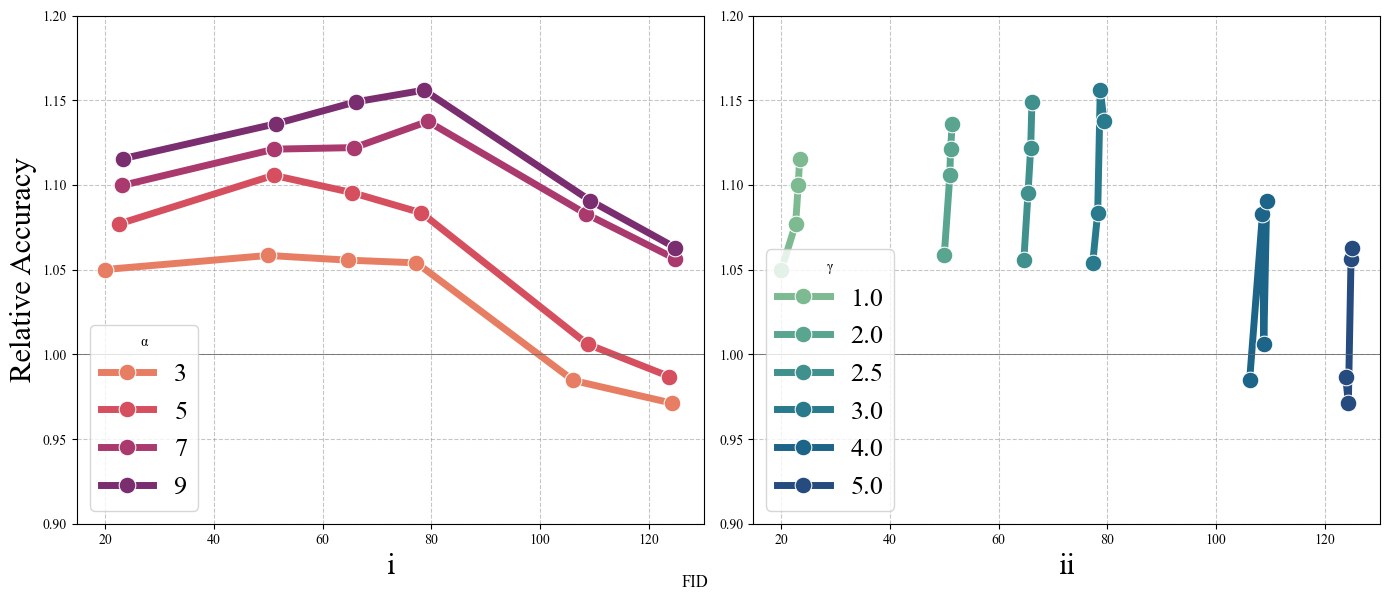

In [54]:
conv_acc_vs_fid_double_plotname = "Images/acc_vs_fid_conv_double.pdf"

# Create a figure with two subplots side by side
ylim = [0.9, 1.2]

fig, axes = plt.subplots(1, 2, figsize=(my_fig_size[0]*2, my_fig_size[1]))  # 1 row, 2 columns

# Plot 1: Constant Alpha (varying Gamma)
sns.lineplot(ax=axes[0], data=med_plot_df, x='fids', y='accs', hue='α', marker='o', markersize = 12, linewidth = 5, palette=sns.color_palette("flare", n_colors=4))
if plot_titles:
    axes[0].set_title('Lines are constant α as γ varies', fontsize = title_size)
axes[0].set_xlabel('i', fontsize = label_size)
axes[0].set_ylabel('Relative Accuracy', fontsize = label_size)
axes[0].legend(title='α', fontsize=legend_size)
axes[0].grid(True, **grid_params)
# axes[0].axhline(y=1, color='gray', linestyle='--', lw = 2.5)
plot_baseline(ax = axes[0])
axes[0].set_ylim(ylim)

# Plot 2: Constant Gamma (varying Alpha)
sns.lineplot(ax=axes[1], data=med_plot_df, x='fids', y='accs', hue='γ', marker='o', markersize = 12, linewidth = 5, palette=sns.color_palette("crest"))
if plot_titles:
    axes[1].set_title('Lines are constant γ as α varies', fontsize = title_size)
axes[1].set_xlabel('ii', fontsize = label_size)
axes[1].set_ylabel('', fontsize = label_size)
axes[1].legend(title='γ', fontsize=legend_size)
axes[1].grid(True, **grid_params)
# axes[1].axhline(y=1, color='gray', linestyle='--', lw = 2.5)
plot_baseline(ax = axes[1])
axes[1].set_ylim(ylim)

# Adjust the layout to make space between subplots
if plot_titles:
    plt.suptitle("Relative Accuracy vs FID for conventional transformations", fontsize = 28)
fig.text(0.5, 0.02, 'FID', ha='center', va='center', fontsize=12)
plt.tight_layout()

if save_plots:
    plt.savefig(conv_acc_vs_fid_double_plotname, format="pdf", bbox_inches="tight")

plt.show()


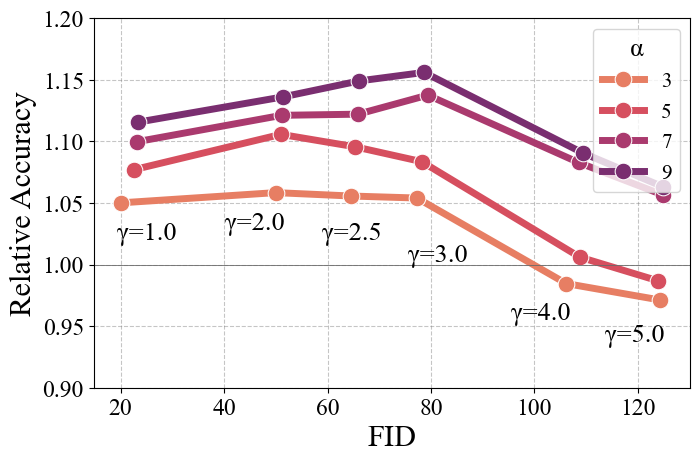

In [55]:
conv_acc_vs_fid_plotname = "Images/acc_vs_fid_conv.pdf"

# Create a single plot
ylim = [0.9, 1.2]

fig, ax = plt.subplots(figsize=(my_fig_size[0]*1.1, my_fig_size[1]*0.8))

# Plot: Constant Alpha (varying Gamma)
sns.lineplot(ax=ax, data=med_plot_df, x='fids', y='accs', hue='α', marker='o', 
             markersize=12, linewidth=5, palette=sns.color_palette("flare", n_colors=4))

# Annotate bottom line with gamma values
bottom_line_alpha = 3  # The alpha value for which to annotate
gamma_values = med_plot_df['γ'].unique()
fids_for_alpha_3 = med_plot_df.loc[med_plot_df['α'] == bottom_line_alpha, 'fids'].values
accs_for_alpha_3 = med_plot_df.loc[med_plot_df['α'] == bottom_line_alpha, 'accs'].values

for i, (fid, acc, gamma) in enumerate(zip(fids_for_alpha_3, accs_for_alpha_3, gamma_values)):
    if i == 0:
        x_offset = 5
        y_offset = -0.03
    elif i == 1:
        x_offset = -4
        y_offset = -0.03
    elif i == 2:
        x_offset = 0
        y_offset = -0.035
    elif i == 3:
        x_offset = 4
        y_offset = -0.052
    elif i == 4:
        x_offset = -5
        y_offset = -0.029
    else:
        x_offset = -5
        y_offset = -0.034
    ax.text(fid + x_offset, acc + y_offset, f'γ={gamma}', fontsize=19, ha='center', color='black')  # Adjust placement

# Adjust tick visibility and font size
ax.tick_params(axis='both', which='major', labelsize=tick_size)
if plot_titles:
    ax.set_title('Relative Accuracy vs FID for Conventional Transformations', fontsize=title_size)
ax.set_xlabel('FID', fontsize=label_size)
ax.set_ylabel('Relative Accuracy', fontsize=label_size)
# ax.legend(title='α', fontsize=12, title_fontsize=legend_size)#, bbox_to_anchor=(1, 1))
handles, labels = ax.get_legend_handles_labels()  # Get legend info
ax.legend(handles=handles, labels=[3, 5, 7, 9], title='α', fontsize=legend_size*0.8, title_fontsize=legend_size, loc="upper right")#, bbox_to_anchor=(1, 1)

ax.grid(True, **grid_params)
# ax.axhline(y=1, color='gray', linestyle='--', lw=2.5)
plot_baseline(ax = ax)
ax.set_ylim(ylim)

# plt.tight_layout()

if save_plots:
    plt.savefig(conv_acc_vs_fid_plotname, format="pdf", bbox_inches="tight")

plt.show()

### ImageGPT

In [56]:
igpt_score_csv_path = "scores/igpt_score_df.csv"

if recalculate_results:
     # Calculate classification accuracy & FID for seed 42 (the initial set of results)
    print("Progress :: For running on first igpt set (seed 42), importing ImageGPT data")
    synthetic_datasets, synthetic_label_sets = utils.synthetic_data_import(folder_path = "data/image_gpt_tidied/synthetic_cifar_seed_42", split_by_type = True)

    scores_dict = {}
    seed = 42
    train_samp = utils.data_sampler(train_dataset, N, rand_seed = seed) # function from igpt_generator file
    x_train_true = [item[0] for item in train_samp]
    y_train_true = [item[1] for item in train_samp]
    images_true = torch.stack(x_train_true)
    print("Progress :: Calculating classification accuracy")
    CNN_params, baseline_test_acc, accuracy_dict = utils.classifier_accuracies(synthetic_datasets, synthetic_label_sets, train_samp, test_dataset, 
                                                    syn_augment=True, images_true=images_true, y_train_true=y_train_true, device=device, device_name=device_name,
                                                    augment=False) # this augment is additional conv-aug on top of the igpt augmentation
    scores_dict["class_acc"] = accuracy_dict 

    print("Progress :: Calculating FID")
    fid_inf_dict = utils.calculate_fid_infs(synthetic_datasets, images_true, device, min_fake=900)
    scores_dict["fid_inf"] = fid_inf_dict

    score_df = utils.scores_compile(synthetic_datasets, scores_dict, baseline_test_acc)

    # this code does the same for the other seeds' datasets
    igpt_score_df, acc_index_df, experiment_count = utils.calc_err_bars(score_df=score_df, other_seeds_path="data/image_gpt_tidied/synthetic_cifar_43_to_47.zip", train_dataset=train_dataset, 
                                                                    n_samp=N, test_dataset=test_dataset, CNN_params=CNN_params, syn_augment = True, 
                                                                    images_true=images_true, y_train_true=y_train_true, 
                                                                    baseline_test_acc=baseline_test_acc, device=device, device_name=device_name,
                                                                    zipped=True, augment=False)
    igpt_score_df.to_csv(igpt_score_csv_path, index=False)
else:
    igpt_score_df = pd.read_csv(igpt_score_csv_path)
    

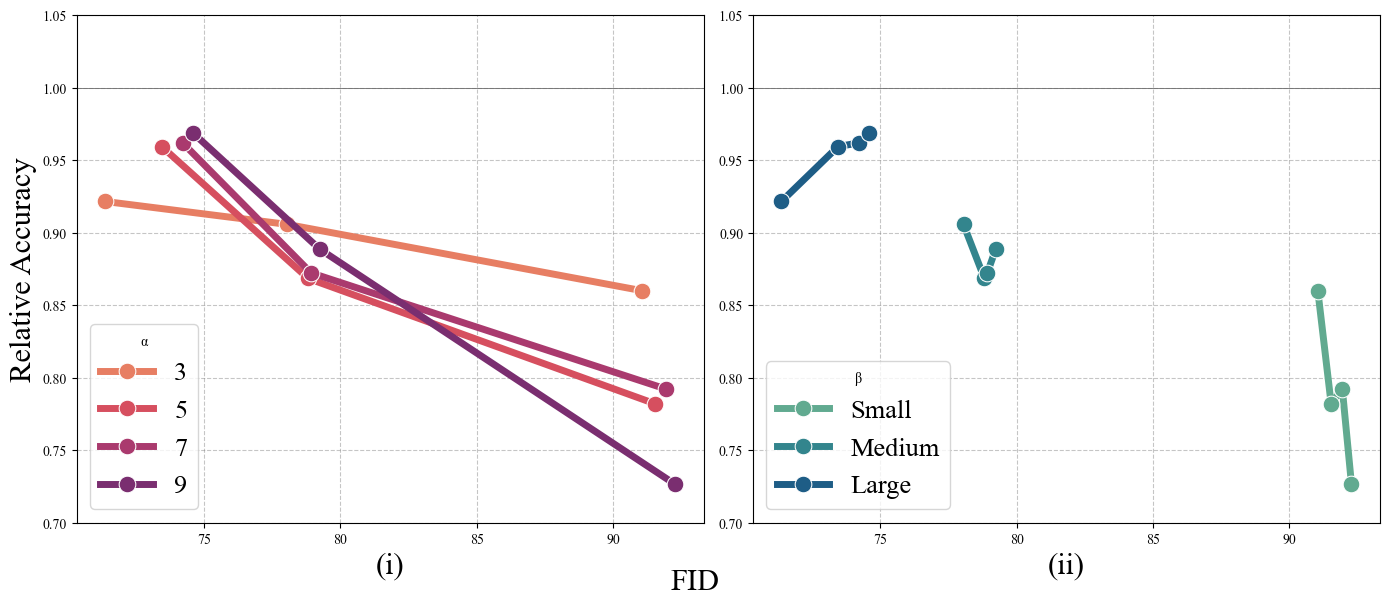

In [57]:
igpt_acc_vs_fid_double_plotname = "Images/acc_vs_fid_igpt_double.pdf"

ylim = [0.7, 1.05]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(my_fig_size[0]*2, my_fig_size[1]))  # 1 row, 2 columns

# Plot 1: Constant Gamma (varying Alpha)
lineplot1 = sns.lineplot(ax=axes[0], data=igpt_score_df, x='med_fid', y='med_acc_ind', hue='reps', 
                         marker='o', markersize=12, linewidth=5, palette=sns.color_palette("flare", n_colors=4))
if plot_titles:
    axes[0].set_title('Lines are constant α as β varies', fontsize=title_size)
axes[0].set_xlabel('(i)', fontsize=label_size)
axes[0].set_ylabel('Relative Accuracy', fontsize=label_size)
handles1, labels1 = axes[0].get_legend_handles_labels()  # Get handles and labels
axes[0].legend(handles=handles1, labels=[3, 5, 7, 9], title='α', fontsize=legend_size)  # Manually set the labels
axes[0].grid(True, **grid_params)
# axes[0].axhline(y=1, color='gray', linestyle='--', lw=2.5)
plot_baseline(ax = axes[0])
axes[0].set_ylim(ylim)

# Plot 2: Constant Alpha (varying Gamma)
lineplot2 = sns.lineplot(ax=axes[1], data=igpt_score_df, x='med_fid', y='med_acc_ind', hue='prompt_name', 
                         marker='o', markersize=12, linewidth=5, palette=sns.color_palette("crest", n_colors=3))
if plot_titles:
    axes[1].set_title('Lines are constant β as α varies', fontsize=title_size)
axes[1].set_xlabel('(ii)', fontsize=label_size)
axes[1].set_ylabel('', fontsize=label_size)
handles2, labels2 = axes[1].get_legend_handles_labels()  # Get handles and labels
axes[1].legend(handles=handles2, labels=["Small", "Medium", "Large"], title='β', fontsize=legend_size)  # Manually set the labels
axes[1].grid(True, **grid_params)
# axes[1].axhline(y=1, color='gray', linestyle='--', lw=2.5)
plot_baseline(ax = axes[1])
axes[1].set_ylim(ylim)

# Adjust the layout to make space between subplots
if plot_titles:
    plt.suptitle("Relative Accuracy vs FID for ImageGPT", fontsize=title_size)
fig.text(0.5, 0.02, 'FID', ha='center', va='center', fontsize=label_size)
plt.tight_layout()

if save_plots:
    plt.savefig(igpt_acc_vs_fid_double_plotname, format="pdf", bbox_inches="tight")

plt.show()

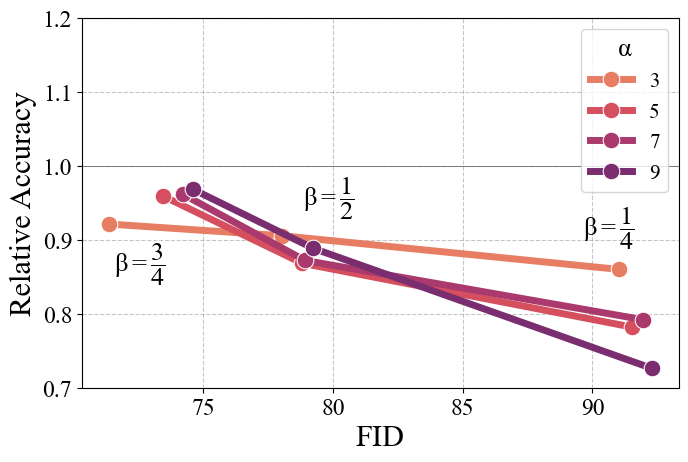

In [58]:
igpt_acc_vs_fid_plotname = "Images/acc_vs_fid_igpt.pdf"

ylim = [0.7, 1.2]

# Create a single plot
fig, ax = plt.subplots(figsize=(my_fig_size[0]*1.1, my_fig_size[1]*0.8))

# Plot: Constant Alpha (varying Beta)
sns.lineplot(ax=ax, data=igpt_score_df, x='med_fid', y='med_acc_ind', hue='reps', 
             marker='o', markersize=12, linewidth=5, palette=sns.color_palette("flare", n_colors=4))

# Annotate bottom line with beta values
bottom_line_alpha = 3  # The alpha value for which to annotate
bottom_line_reps = bottom_line_alpha-1
beta_values = igpt_score_df['prompt_val'].unique()  # Unique beta values
fids_for_alpha_3 = igpt_score_df.loc[igpt_score_df['reps'] == bottom_line_reps, 'med_fid'].values
accs_for_alpha_3 = igpt_score_df.loc[igpt_score_df['reps'] == bottom_line_reps, 'med_acc_ind'].values

for i, (fid, acc, beta) in enumerate(zip(fids_for_alpha_3, accs_for_alpha_3, beta_values)):
    if i == 2:
        x_offset = 1.2
        y_offset = -0.065
    elif i == 1:
        x_offset = 1.8
        y_offset = 0.04
    else:
        x_offset = -0.4
        y_offset = 0.045

    # Formatting the beta value as a LaTeX formatted fraction, using \dfrac for a larger fraction
    beta_str = fr"$\beta=\dfrac{{{Fraction(beta).limit_denominator().numerator}}}{{{Fraction(beta).limit_denominator().denominator}}}$"
    # Adjust the placement of the annotation
    ax.text(fid + x_offset, acc + y_offset, beta_str, fontsize=19, ha='center', color='black') # Adjust placement

# Adjust tick visibility and font size
ax.tick_params(axis='both', which='major', labelsize=tick_size)

if plot_titles:
    ax.set_title('Relative Accuracy vs FID for ImageGPT', fontsize=title_size)
ax.set_xlabel('FID', fontsize=label_size)
ax.set_ylabel('Relative Accuracy', fontsize=label_size)
handles, labels = ax.get_legend_handles_labels()  # Get legend info
ax.legend(handles=handles, labels=[3, 5, 7, 9], title='α', loc = "upper right", fontsize=legend_size*0.8, title_fontsize=legend_size)#, bbox_to_anchor=(1, 1)
ax.grid(True, **grid_params)
# ax.axhline(y=1, color='gray', linestyle='--', lw=2.5)
plot_baseline(ax = ax)
ax.set_ylim(ylim)

if save_plots:
    plt.savefig(igpt_acc_vs_fid_plotname, format="pdf", bbox_inches="tight")

plt.show()

## Accuracy vs alpha
### Define our colour scheme

In [59]:
qualitative_palette = sns.color_palette("deep", 10)

# Define the ImageGPT color (2nd color) and GAN color (3rd color)
imagegpt_color = qualitative_palette[1]  # 2nd color for ImageGPT
gan_color = qualitative_palette[2]  # 3rd color for GAN

# Create custom sequential palettes
def create_similar_colors_palette(base_color, num_colors):
    # Convert base RGB color to HLS
    r, g, b = base_color
    h, l, s = colorsys.rgb_to_hls(r, g, b)

    # Create a list of similar colors
    if num_colors >= 3:
        hues = np.linspace(h - 0.055, h + 0.055, num_colors)  # Keep hue similar
        lightness = np.linspace(0.45, 0.6, num_colors)  # Adjust lightness for variety
    else:
        hues = np.linspace(h - 0.09, h + 0.09, num_colors)  # Keep hue similar
        lightness = np.linspace(0.4, 0.55, num_colors)  # Adjust lightness for variety
    saturation = s  # Keep saturation the same

    # Convert HLS back to RGB and return as a seaborn palette
    similar_colors = [colorsys.hls_to_rgb(hue, l, saturation) for hue, l in zip(hues, lightness)]
    return sns.color_palette(similar_colors)


# Create ImageGPT palette with variations
imagegpt_palette = create_similar_colors_palette(imagegpt_color, 3)
# Create GAN palette with variations
gan_palette = create_similar_colors_palette(gan_color, 2)

# Combine all palettes into a single custom palette
custom_palette = [
    qualitative_palette[4],  # Conventional
    *imagegpt_palette,       # ImageGPT iterations
    *gan_palette,            # GAN iterations
    qualitative_palette[5]   # Original Only
]

### Start with conventional augs baseline

In [60]:
recalculate_results = False
# other_seeds = False

In [61]:
# conv_scores_filename = 'scores/conv_10run_scores.json'

# gamma = 3
# alphas = [1, 3, 5, 7, 9]
# alphas = [1, 3, 5, 7, 9, 10, 12, 15, 20]

# repeats = 25
# recalculate_results = True


In [62]:
conv_scores_filename = 'scores/conv_10run_scores.json'

if recalculate_results:
    conv_scores_dict = {} 
    for repeat in range(repeats):
        print(f"Progress :: Calculating accuracy scores for conventional augs, repeat {repeat + 1} of {repeats}")

        conv_scores_rep = {}
        for alpha in alphas:
            if alpha == 1:
                conv_scores_rep[alpha] = 1
            else:
                CNN_params_dict = utils.CNN_params_setup(device)
                dropout_conv = CNN_params_dict["dropout_conv"]; dropout_fc = CNN_params_dict["dropout_fc"]
                cnn_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, test_acc = utils.nn_trainer(cnn_model, subset_train_dataset, test_dataset, opt_type = "adam", CNN_params_dict=CNN_params_dict, 
                                                    loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False, 
                                                    augmentation = True, aug_ratio = alpha, aug_var = gamma)
                conv_scores_rep[alpha] = test_acc
        conv_scores_dict[repeat] = conv_scores_rep
    json.dump(conv_scores_dict, open(conv_scores_filename, 'w'))
else:
    conv_scores_dict = json.load(open(conv_scores_filename, 'r'))
    

### Conventional vs ImageGPT

In [63]:
# synthetic_datasets, synthetic_label_sets = utils.synthetic_data_import(folder_path = "data/image_gpt_tidied/synthetic_cifar_seed_42", split_by_type = True)
# seed = 42
# train_samp = utils.data_sampler(train_dataset, N, rand_seed = seed) # function from igpt_generator file
# x_train_true = [item[0] for item in train_samp]
# y_train_true = [item[1] for item in train_samp]
# images_true = torch.stack(x_train_true)
# ##############

In [64]:
# import zipfile

# def synthetic_type_split_import(folder_path, split_method, name_cond = None, zipped = False, prompt_set = "full"):
#     """Function to support the ImageGPT synthetic data import. 
#     If desired to split the data by type, then this function is run. 
#     Args:
#         folder_path (str): Filepath (relative to current file) of the folder of synthetic images to import
#         split_method (str): E.g. "prompt_rep", the method with which to split the data (prompt_rep does this by prompt size name and rep size number)
#         name_cond (str or None, optional): Whether to only select images whose name select a certain string. Set to None if no such filtering desired. Defaults to None.
#         zipped (bool, optional): If the selected folder is zipped, need to additionally unzip in the process. Defaults to False.
#         prompt_set (str or list, optional): The set of prompts to use. Either "full" for the default 12: s/m/l 2/4/6/8, or specify a list. Defaults to "full"
#     Returns:
#         synthetic_datasets, synthetic_label_sets: dictionaries of the split datasets and label_sets, keyed by the split method (e.g. prompt & rep sizes)
#     """
#     if split_method == "prompt_rep":
#         # To sort them by prompt and rep size for training the different classifiers, 
#         # make a dict of 12 synthetic datasets (and 12 label sets) for all prompt size & rep size combos
#         if prompt_set == "full":
#             prompt_sizes = ['small', 'med', 'large']
#             rep_sizes = ['2', '4', '6', '8']
#             rep_sizes = ['2', '4', '6', '8', '9', '11', '14', '19']
#         else:
#             prompt_sizes = list(set(item.split('-')[0] for item in prompt_set))
#             rep_sizes = list(set(item.split('-')[1] for item in prompt_set))
#             assert set(prompt_sizes).issubset(['small', 'med', 'large']), "Invalid prompts found"
#             assert all(rep.isdigit() for rep in rep_sizes), "Invalid reps found"

#         synthetic_datasets = {}; synthetic_label_sets = {}
#         for prompt in prompt_sizes:
#             for rep in rep_sizes:
#                 synthetic_datasets[prompt + '-' + rep] = None
#                 synthetic_label_sets[prompt + '-' + rep] = []
#         if zipped:
#             with zipfile.ZipFile(folder_path, 'r') as zip_ref:
#                 file_names = sorted(zip_ref.namelist())
#                 skipped_elts = file_names[0:1]
#                 if any ('.png' in element for element in skipped_elts):
#                     raise ValueError("Accidentally deleted synthetic image while unzipping folder.")
#                 file_names = file_names[1:]
#             for filename, image in utils.zipped_image_generator(folder_path, file_names):
#                 if filename.endswith('.png'): # Check is a png
#                     if name_cond is None or name_cond in filename: # If no name_cond filter is specified, or if the desired string IS in the current filename, continue
#                         if image is not None: # save the image
#                             # Get the prompt & rep sizes from the image title
#                             prompt = filename[:filename.find('-prompt')]
#                             rep = filename[filename.find('rep-size_')+len('rep-size_')]
#                         # Initialize a 4D array if it's not already initialized to store the data in
#                             if synthetic_datasets[prompt + '-' + rep] is None:
#                                 synthetic_datasets[prompt + '-' + rep] = np.transpose(image, (2, 0, 1))[np.newaxis, ...]  # reshape the image to 3 x 32 x 32 as that's how the classifier is set up and add to 4D array
#                             else:
#                                 # Append the current image to the 4D array
#                                 synthetic_datasets[prompt + '-' + rep] = np.vstack((synthetic_datasets[prompt + '-' + rep], np.transpose(image, (2, 0, 1))[np.newaxis, ...]))
#                             label_index = filename.find('label-') # And save the corresponding label for classification
#                             if label_index != -1:
#                                 label_value = int(filename[label_index+len('label-')])
#                                 synthetic_label_sets[prompt + '-' + rep].append(label_value)
#                             else:
#                                 raise ValueError(f"No label found for image {filename}")
                            
#         else:
#             for filename in os.listdir(folder_path): # Loop through all files in the folder
#                 if filename.endswith('.png'): # Check is a png
#                     if name_cond is None or name_cond in filename: # If no name_cond filter is specified, or if the desired string IS in the current filename, continue
#                         image_path = os.path.join(folder_path, filename)
#                         image = cv2.imread(image_path) # Read it as an image (reads to n x n x 3 BGR numpy array)
#                         if image is not None: # save the image
#                             # Get the prompt & rep sizes from the image title
#                             prompt = filename[:filename.find('-prompt')]
#                             # rep = filename[filename.find('rep-size_')+len('rep-size_')]
#                             start = filename.find('rep-size_') + len('rep-size_')
#                             end = filename.find('_', start)  # Find the next underscore after 'rep-size_'
#                             rep = filename[start:end]  # Extract the substring between 'rep-size_' and the next underscore


#                         # Initialize a 4D array if it's not already initialized to store the data in
#                             if synthetic_datasets[prompt + '-' + rep] is None:
#                                 synthetic_datasets[prompt + '-' + rep] = np.transpose(image, (2, 0, 1))[np.newaxis, ...]  # reshape the image to 3 x 32 x 32 as that's how the classifier is set up and add to 4D array
#                             else:
#                                 # Append the current image to the 4D array
#                                 synthetic_datasets[prompt + '-' + rep] = np.vstack((synthetic_datasets[prompt + '-' + rep], np.transpose(image, (2, 0, 1))[np.newaxis, ...]))
#                             label_index = filename.find('label-') # And save the corresponding label for classification
#                             if label_index != -1:
#                                 label_value = int(filename[label_index+len('label-')])
#                                 synthetic_label_sets[prompt + '-' + rep].append(label_value)
#                             else:
#                                 raise ValueError(f"No label found for image {filename}")
                    
#         # save the images as floats between 0 and 1
#         for key, value in synthetic_datasets.items():
#             if value is not None: # in case the dict is empty
#                 new_val = value/255
#                 synthetic_datasets[key] = new_val
#                 assert ((new_val >= 0).all() and (new_val <= 1).all()), f"image data needs to be in range [0, 1] for array `new_val` in synthetic dataset {key}"

#         return synthetic_datasets, synthetic_label_sets
#     else:
#         raise ValueError(f"Unknown method to categorise/split the synthetic data provided by `split_method`={split_method}")
 

# def synthetic_data_import(folder_path, zipped = False, split_by_type = False, split_method = "prompt_rep", seed_subset = False, prompt_set = "full"):
#     """Function to import the synthetic images from a given folder, and split by type or seed if desired to create different datasets.
#     Args:
#         folder_path (str): Filepath (relative to current file) of the folder of synthetic images to import
#         zipped (bool): If the selected folder is zipped, need to additionally unzip in the process. Defaults to False.
#         split_by_type (str): Whether to split the output data by type (as specified in split_method). Defaults to False.
#         split_method (str): The method with which to split the data (prompt_rep does this by prompt size name and rep size number). Defaults to \'prompt_rep\'".
#         seed_subset (bool, optional): If desired to also output the data as split by the seed in the image name. Defaults to False.
#         prompt_set (str or list, optional): The set of prompts to use. Either "full" for the default 12: s/m/l 2/4/6/8, or specify a list. Defaults to "full"
#     Returns:
#         if split_by_type: 
#             if seed_subset: synthetic_datasets_by_seed, synthetic_label_sets_by_seed, each dictionaries keyed by the seed values in the image names. 
#                             Each element of the dictionary is a dictionary of datasets, keyed by the split method (e.g. prompt & rep sizes)
#             else not seed_subset: synthetic_datasets, synthetic_label_sets, dictionaries of datasets keyed by the split method (e.g. prompt & rep sizes)
#         else not split_by_type: raw_syn_data, a 4D tensor of the images (e.g. n x 32 x 32 x 3 for the CIFAR data), and labels, a 1D list of correpsonding labels
#     """
#     if split_by_type: # this will separate the images out by prompt and replication size
#         if seed_subset:
#             if zipped:
#                 file_list = zipfile.ZipFile(folder_path, 'r').namelist()
#                 skipped_elts = file_list[0:1]
#                 if any ('.png' in element for element in skipped_elts):
#                     raise ValueError("Accidentally deleted synthetic image while unzipping folder.")
#                 file_list = file_list[1:]
#             else:
#                 file_list = os.listdir(folder_path)
#             seed_values = set()
#             for file_name in file_list:
#                 if "_seed_" in file_name:
#                     start_index = file_name.find("_seed_") + len("_seed_")
#                     end_index = file_name.find("_", start_index)
#                     seed_value = file_name[start_index:end_index]
#                     seed_values.add(seed_value)
#                 else:
#                     raise ValueError(f"Unexpected name \"{file_name}\" for image in {folder_path}, was expecting to include\"_seed_\"")
#             seed_values = sorted(seed_values)

#             synthetic_datasets_by_seed = {}; synthetic_label_sets_by_seed = {}
#             for seed in seed_values:
#                 synthetic_result = synthetic_type_split_import(folder_path, split_method, name_cond = "_seed_"+seed, zipped = zipped)
#                 synthetic_datasets_by_seed[seed] = synthetic_result[0]
#                 synthetic_label_sets_by_seed[seed] = synthetic_result[1]
#             return synthetic_datasets_by_seed, synthetic_label_sets_by_seed

#         else:
#             synthetic_datasets, synthetic_label_sets = synthetic_type_split_import(folder_path, split_method, zipped = zipped, prompt_set = prompt_set)
#             return synthetic_datasets, synthetic_label_sets

#     else: # Otherwise, instead of splitting by prompt & rep size, just load in as a 4D tensor
#         if seed_subset:
#             raise NotImplementedError("I haven't yet coded doing subsetting by seed for the non-type-split data output.")
#         raw_syn_data = []
#         labels = []
#         for filename in os.listdir(folder_path): # Loop through all files in the folder
#             if filename.endswith('.png'): # Check is a png
#                 image_path = os.path.join(folder_path, filename)
#                 image = cv2.imread(image_path) # Read it as an image (reads to n x n x 3 BGR numpy array)
#                 raw_syn_data.append(image)
            
#             # Get the label
#             label_index = filename.find('label-')
#             if label_index != -1:
#                 label = int(filename[label_index+len('label-')])
#             else:
#                 raise ValueError(f"No label found for image {filename}")
#             labels += [label]

#         # save the images as floats between 0 and 1
#         for i in range(len(raw_syn_data)):
#             image = raw_syn_data[i]/255
#             assert ((image >= 0).all() and (image <= 1).all()), f"image data needs to be in range [0, 1] for array `new_val` in synthetic dataset"
#             raw_syn_data[i] = image
        
#         # Save as a 4D torch tensor of images as 1D list of labels
#         raw_syn_data = np.stack(raw_syn_data, axis = 0)
#         raw_syn_data = torch.from_numpy(raw_syn_data).to(dtype=torch.float32)
#         raw_syn_data = raw_syn_data.permute(0, 3, 1, 2) # ensures consistent data structure
#         return raw_syn_data, labels


In [65]:
igpt_scores_filename = 'scores/igpt_6run_scores.csv'
if recalculate_results:
    other_seeds_path="data/image_gpt_tidied/synthetic_cifar_43_to_47.zip"

    scores_dict = {}
    baseline_accs_dict = {}

    # Calculate the baseline real-data accuracy, and the classifier accuracy for each synthetic set
    CNN_params, baseline_test_acc, accuracy_dict = utils.classifier_accuracies(synthetic_datasets, synthetic_label_sets, train_samp, test_dataset, 
                                                    syn_augment=True, images_true=images_true, y_train_true=y_train_true, device=device, device_name=device_name,
                                                    augment=False) # this augment is additional conv-aug on top of the igpt augmentation
    
    scores_dict[42] = accuracy_dict 
    baseline_accs_dict[42] = baseline_test_acc


    synthetic_datasets_by_seed, synthetic_label_sets_by_seed = utils.synthetic_data_import(other_seeds_path, split_by_type = True, split_method = "prompt_rep", seed_subset = True, zipped = True)
    print("Progress :: To plot accuracy error bars, computing classifier accuracies for other synthetic datasets.")
    accuracies_dict = {}
    baseline_accuracies_dict = {}
    fids_dict = {}
    if other_seeds:
        for seed, syn_data_dict in synthetic_datasets_by_seed.items():
            print(f"Progress :: Computing accuracies for seed {seed} out of {list(synthetic_datasets_by_seed.keys())}")
            seed_baseline_test_acc, seed_accuracy_dict = utils.seed_subset_accuracies(seed, syn_data_dict, synthetic_label_sets_by_seed, train_dataset, N, test_dataset, True, 
                                                                images_true, y_train_true, device, device_name, augment=False)

            accuracies_dict[seed] = seed_accuracy_dict
            baseline_accuracies_dict[seed] = seed_baseline_test_acc

    # Convert dictionaries to dataframe
    df_scores = pd.DataFrame(scores_dict).T

    # Divide each value by the corresponding baseline score
    rel_score_df = df_scores.div(pd.Series(baseline_accs_dict), axis=0)

    rel_score_df.to_csv(igpt_scores_filename)
else:
    rel_score_df = pd.read_csv(igpt_scores_filename, index_col = 0)

# !!!!!!!!

In [67]:
igpt_scores_filename = 'scores/take_2_igpt_6run_scores.csv'
recalculate_results = False

other_seeds_path="more_igpt_data/synthetic_cifar_43_to_47.zip"

if recalculate_results:
    print("Progress :: Importing data")
    train_samp = utils.data_sampler(train_dataset, N, rand_seed = seed) # function from igpt_generator file
    x_train_true = [item[0] for item in train_samp]
    y_train_true = [item[1] for item in train_samp]
    images_true = torch.stack(x_train_true)

    synthetic_datasets, synthetic_label_sets = utils.synthetic_data_import(folder_path = "more_igpt_data/synthetic_cifar_seed_42", split_by_type = True)
    other_seeds_path="more_igpt_data/synthetic_cifar_43_to_47.zip"
    
    scores_dict = {}
    baseline_accs_dict = {}

    print("Progress :: Accuracies for 'base' iGPT set - set 42")
    # Calculate the baseline real-data accuracy, and the classifier accuracy for each synthetic set
    CNN_params, baseline_test_acc, accuracy_dict = utils.classifier_accuracies(synthetic_datasets, synthetic_label_sets, train_samp, test_dataset, 
                                                    syn_augment=True, images_true=images_true, y_train_true=y_train_true, device=device, device_name=device_name,
                                                    augment=False) # this augment is additional conv-aug on top of the igpt augmentation
    
    scores_dict[42] = accuracy_dict 
    baseline_accs_dict[42] = baseline_test_acc

    synthetic_datasets_by_seed, synthetic_label_sets_by_seed = utils.synthetic_data_import(other_seeds_path, split_by_type = True, split_method = "prompt_rep", seed_subset = True, zipped = True)

    print("Progress :: To plot accuracy error bars, computing classifier accuracies for other synthetic datasets.")
    accuracies_dict = {}
    baseline_accuracies_dict = {}
    fids_dict = {}


In [69]:
other_seeds = True    
if recalculate_results:
    if other_seeds:
        for seed, syn_data_dict in synthetic_datasets_by_seed.items():
            print(f"Progress :: Computing accuracies for seed {seed} out of {list(synthetic_datasets_by_seed.keys())}")
            seed_baseline_test_acc, seed_accuracy_dict = utils.seed_subset_accuracies(seed, syn_data_dict, synthetic_label_sets_by_seed, train_dataset, N, test_dataset, True, 
                                                                images_true, y_train_true, device, device_name, augment=False)

            accuracies_dict[seed] = seed_accuracy_dict
            baseline_accuracies_dict[seed] = seed_baseline_test_acc

    # Convert dictionaries to dataframe
    df_scores = pd.DataFrame(scores_dict).T

    # Divide each value by the corresponding baseline score
    rel_score_df = df_scores.div(pd.Series(baseline_accs_dict), axis=0)

    rel_score_df.to_csv(igpt_scores_filename)

else:
    rel_score_df = pd.read_csv(igpt_scores_filename, index_col = 0)

In [70]:
# # Convert dictionaries to dataframe
# df_scores = pd.DataFrame(scores_dict).T

# # Divide each value by the corresponding baseline score
# rel_score_df = df_scores.div(pd.Series(baseline_accs_dict), axis=0)

# rel_score_df.to_csv(igpt_scores_filename)

In [71]:
# General function to plot with IQR error bars for both relative and conventional data
def plot_with_iqr(df, column_groups, labels, colors, lw=3.2):
    median = df.median()
    q1 = df.quantile(0.25); q3 = df.quantile(0.75)

    error_lower = median - q1; error_upper = q3 - median

    for cols, label, color in zip(column_groups, labels, colors):
        plt.errorbar(alphas, median[cols], 
                     yerr=[error_lower[cols], error_upper[cols]], 
                     fmt='-o', label=label, color=color, lw=lw,
                     markeredgecolor='white', markeredgewidth=0.5, markersize=8)

In [72]:
alphas = [1, 3, 5, 7, 9, 10, 12, 15, 20]
alphas = [1, 3, 5, 7, 10, 12, 15, 20]


rel_score_df


,large-11,large-14,large-19,large-2,large-4,large-6,large-8,large-9,med-11,med-14,...,med-8,med-9,small-11,small-14,small-19,small-2,small-4,small-6,small-8,small-9
42,0.968628,0.967169,1.022374,0.98784,1.015564,1.048395,1.029183,1.043531,0.869163,0.873784,...,0.826119,0.871839,0.712792,0.680204,0.642753,0.867947,0.768726,0.734193,0.707442,0.690418


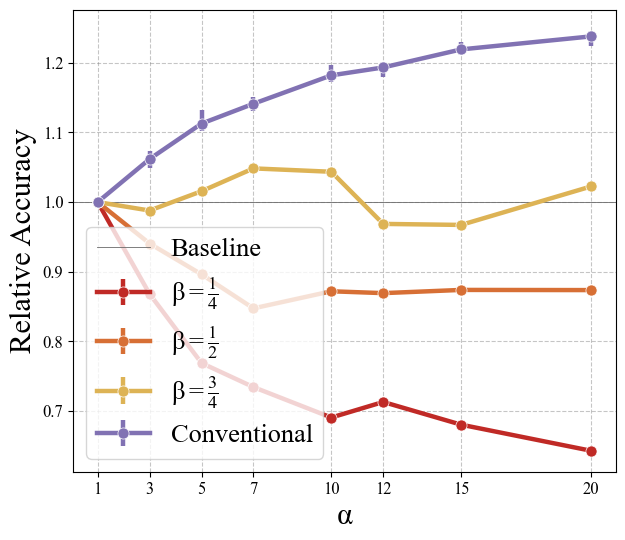

In [73]:
acc_conv_vs_igpt_plotname = "Images/acc_conv_vs_igpt.pdf"

# Prepare the baseline data
conv_df = pd.DataFrame(conv_scores_dict).T
normalized_conv_df = conv_df / avg_baseline_accuracy
normalized_conv_df.iloc[:, 0] = 1

# Define x-values and columns for plotting
rel_score_df[['small-0', 'med-0', 'large-0']] = 1

# Define column groupings, labels, and colors
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-8'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-8'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-8']]
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-9', 'small-11', 'small-14', 'small-19'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-9', 'med-11', 'med-14', 'med-19'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-9', 'large-11', 'large-14', 'large-19']]

labels = [r"$\beta = \frac{1}{4}$", r"$\beta = \frac{1}{2}$", r"$\beta = \frac{3}{4}$"]
colors = imagegpt_palette

# Create the plot
plt.figure(figsize=my_fig_size)

# Plot iGPT data
plot_with_iqr(rel_score_df, column_groups, labels, colors)

# Plot conventional data
plot_with_iqr(normalized_conv_df, [normalized_conv_df.columns], ['Conventional'], [custom_palette[0]])

# plt.axhline(y=1, ls="--", lw=3, color='gray', alpha=1, label='Baseline')
plot_baseline(label = 'Baseline')

# Customize plot
plt.xlabel("α", fontsize=label_size)
plt.ylabel("Relative Accuracy", fontsize=label_size)
plt.xticks(alphas, fontsize=tick_size)
plt.yticks(fontsize=tick_size)

if plot_titles:
    plt.title("Relative Accuracy for Conventional against ImageGPT Synthetic", fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=legend_size)
plt.grid(True, **grid_params)

if save_plots:
    plt.savefig(acc_conv_vs_igpt_plotname, format="pdf", bbox_inches="tight")

plt.show()


### Conventional vs GAN

In [74]:
repeats = 10
label_dict = {0: b'airplane', 1: b'automobile', 2: b'bird', 3: b'cat', 4: b'deer', 5: b'dog', 6: b'frog', 7: b'horse', 8: b'ship', 9: b'truck'} # Output from CIFAR10

gan_mod_2_parent_path = "models_save_space/gan_2"
gan_model_2 = {}
for label in cifar10_classes:
    if scripted_models:
        path_to_model = f"{gan_mod_2_parent_path}/label_{label}/generator_scripted.pth"
        gan_model_2[label] = torch.load(path_to_model, map_location=device)
    else:
        path_to_model = f"{gan_mod_2_parent_path}/label_{label}/model/dcgan_generator_{model_version}.pth"
        gan_model_2[label] = torch.load(path_to_model, map_location=device)

gan_mod_4_parent_path = "models_save_space/gan_4"
gan_model_4 = {}
for label in cifar10_classes:
    if scripted_models:
        path_to_model = f"{gan_mod_4_parent_path}/label_{label}/generator_scripted.pth"
        gan_model_4[label] = torch.load(path_to_model, map_location=device)
    else:
        path_to_model = f"{gan_mod_4_parent_path}/label_{label}/model/dcgan_generator_{model_version}.pth"
        gan_model_4[label] = torch.load(path_to_model, map_location=device)         

In [75]:
gan_2_class_dropout_conv = 0.68
gan_4_class_dropout_conv = 0.25
nn_input_size = 150
nn_n_layers_gen = 5

In [76]:
gan_2_score_file_name = "scores/gan_2_scores.json"

if recalculate_results:      
    gan_2_scores_all = {}
    for repeat in range(repeats):
        print(f"Progress :: Calculating accuracy scores for GAN model 2, repeat {repeat + 1} of {repeats}")
        gan_2_scores = {}

        for alpha in alphas:
            if alpha == 1:
                gan_2_scores[alpha] = 1
            else:
                model_type = "v2"
                class_train_datalist_samp, _, _ = utils.train_sampler(train_dataset, N, seed = seed)
                samp_images, samp_labels = zip(*class_train_datalist_samp)
                # Convert them to tensors if they aren't already
                samp_images = torch.stack(samp_images)  # Stack image tensors into a single tensor
                samp_labels = torch.tensor(samp_labels) # Convert labels to a tensor
                # Create the TensorDataset
                class_train_dataset_samp = TensorDataset(samp_images, samp_labels)
                # Get synthetic data ready
                class_n_syn = N * alpha
                # class_synthetic_images_dict = test_synthetic_images_dict
                class_synthetic_images_dict = utils.create_gan_imgs(gan_model_2, n_syn = class_n_syn, model_save_type = "scripted", model_type=model_type,
                                                            nn_input_size=nn_input_size, nn_n_layers_gen=nn_n_layers_gen, n_classes = n_classes)

                class_syn_dataset = utils.syn_dict_to_dataset(class_synthetic_images_dict)
                class_aug_dataset = ConcatDataset([class_train_dataset_samp, class_syn_dataset])

                classifer_CNN_params = utils.CNN_params_setup(device)
                dropout_fc = classifer_CNN_params["dropout_fc"]

                # Calculate augmented accuracy
                classifier_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = gan_2_class_dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, aug_test_acc = utils.nn_trainer(classifier_model, class_aug_dataset, test_dataset, device_str = device_name, 
                                                                verbose = False, CNN_params_dict=classifer_CNN_params, augmentation=False)
                relative_accuracy = aug_test_acc/avg_baseline_accuracy
                gan_2_scores[alpha] = relative_accuracy
        gan_2_scores_all[repeat] = gan_2_scores
    json.dump(gan_2_scores_all, open(gan_2_score_file_name, 'w'))
else:
    gan_2_scores_all = json.load(open(gan_2_score_file_name, 'r'))

In [77]:
gan_4_score_file_name = "scores/gan_4_scores.json"

if recalculate_results:      
    gan_4_scores_all = {}
    for repeat in range(repeats):
        print(f"Progress :: Calculating accuracy scores for GAN model 4, repeat {repeat + 1} of {repeats}")
        gan_4_scores = {}

        for alpha in alphas:
            if alpha == 1:
                gan_4_scores[alpha] = 1
            else:
                model_type = "v2"
                class_train_datalist_samp, _, _ = utils.train_sampler(train_dataset, N, seed = seed)
                samp_images, samp_labels = zip(*class_train_datalist_samp)
                # Convert them to tensors if they aren't already
                samp_images = torch.stack(samp_images)  # Stack image tensors into a single tensor
                samp_labels = torch.tensor(samp_labels) # Convert labels to a tensor
                # Create the TensorDataset
                class_train_dataset_samp = TensorDataset(samp_images, samp_labels)
                # Get synthetic data ready
                class_n_syn = N * alpha
                # class_synthetic_images_dict = test_synthetic_images_dict
                class_synthetic_images_dict = utils.create_gan_imgs(gan_model_4, n_syn = class_n_syn, model_save_type = "scripted", model_type=model_type,
                                                            nn_input_size=nn_input_size, nn_n_layers_gen=nn_n_layers_gen, n_classes = n_classes)

                class_syn_dataset = utils.syn_dict_to_dataset(class_synthetic_images_dict)
                class_aug_dataset = ConcatDataset([class_train_dataset_samp, class_syn_dataset])

                classifer_CNN_params = utils.CNN_params_setup(device)
                dropout_fc = classifer_CNN_params["dropout_fc"]

                # Calculate augmented accuracy
                classifier_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = gan_4_class_dropout_conv, dropout_fc = dropout_fc).to(device)
                _, _, aug_test_acc = utils.nn_trainer(classifier_model, class_aug_dataset, test_dataset, device_str = device_name, 
                                                                verbose = False, CNN_params_dict=classifer_CNN_params, augmentation=False)
                relative_accuracy = aug_test_acc/avg_baseline_accuracy
                gan_4_scores[alpha] = relative_accuracy
        gan_4_scores_all[repeat] = gan_4_scores
    json.dump(gan_4_scores_all, open(gan_4_score_file_name, 'w'))
else:
    gan_4_scores_all = json.load(open(gan_4_score_file_name, 'r'))

In [78]:
conv_df = pd.DataFrame(conv_scores_dict).T
normalized_conv_df = conv_df / avg_baseline_accuracy
normalized_conv_df.iloc[:, 0] = 1
normalized_conv_df

,1,3,5,7,10,12,15,20
0,1.0,1.072147,1.112610,1.124204,1.207496,1.182177,1.225716,1.245829
1,1.0,1.036653,1.101725,1.154256,1.173659,1.201581,1.238494,1.226190
2,1.0,1.091077,1.109534,1.135089,1.184070,1.200398,1.221221,1.215068
3,1.0,1.055110,1.089184,1.159225,1.196848,1.180521,1.226663,1.242280
4,1.0,1.033577,1.142424,1.105274,1.175079,1.230686,1.196612,1.279667
5,1.0,1.076170,1.155439,1.146920,1.197085,1.191406,1.170346,1.263103
6,1.0,1.034997,1.143608,1.118762,1.185963,1.180048,1.249615,1.273041
7,1.0,1.064102,1.073093,1.132250,1.199924,1.171529,1.252455,1.239441
8,1.0,1.079009,1.121838,1.116396,1.181231,1.197558,1.182414,1.235655
10,1.0,1.069544,1.130357,1.103145,1.182887,1.199451,1.216961,1.184070


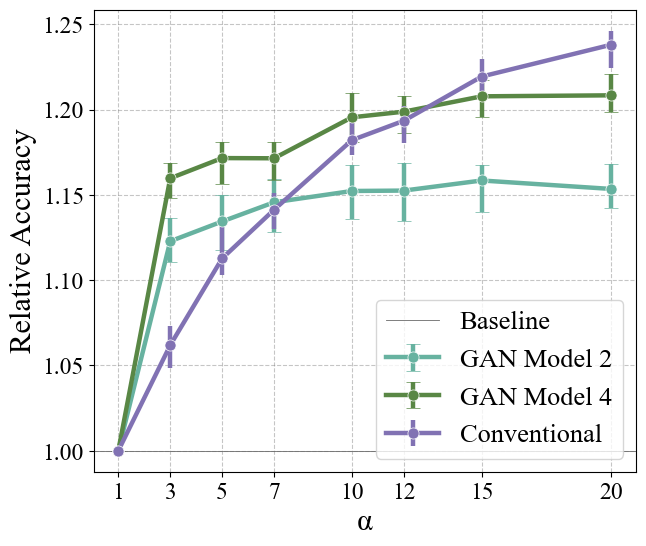

In [79]:
acc_conv_vs_gan_plotname = "Images/conv_vs_gan.pdf"

# Define a function to streamline the plotting
def plot_scores_with_iqr(scores_df, label, color):
    median = scores_df.median()
    q1 = scores_df.quantile(0.25)
    q3 = scores_df.quantile(0.75)

    # Calculate error bars (IQR)
    error_lower = median - q1  # distance from median to Q1
    error_upper = q3 - median  # distance from median to Q3

    # Plot the median line with error bars (for IQR)
    plt.errorbar(scores_df.columns.astype(int), median, yerr=[error_lower, error_upper], 
                 fmt='-o', lw = 3.2, capsize=5, label=label, color = color,
                 markeredgecolor='white', markeredgewidth=0.5, markersize=8)
    return median

gan_2_scores_df = pd.DataFrame(gan_2_scores_all).T
gan_4_scores_df = pd.DataFrame(gan_4_scores_all).T

# Create the plot
plt.figure(figsize=my_fig_size)

# Plot both datasets
gan_2_median = plot_scores_with_iqr(gan_2_scores_df, label='GAN Model 2', color = gan_palette[1])
gan_4_median = plot_scores_with_iqr(gan_4_scores_df, label='GAN Model 4', color = gan_palette[0])

# Plot conventional data
plot_with_iqr(normalized_conv_df, [normalized_conv_df.columns], ['Conventional'], [custom_palette[0]])

# plt.axhline(y=1, ls="--", lw=3, color='gray', alpha=1, label='Baseline')
plot_baseline(label = 'Baseline')

# Add labels and title
plt.xlabel("α", fontsize=label_size)
plt.ylabel('Relative Accuracy', fontsize = label_size)
if plot_titles:
    plt.title("Relative Accuracy for Conventional against GAN Synthetic", fontsize = title_size)
# plt.annotate(f"Error bars showing median & IQR\n across {repeats} tests", xy=(0.5, 0.945), xycoords='axes fraction', fontsize=14, ha='center', va='center')
plt.xticks(alphas, fontsize=tick_size)
plt.yticks(fontsize=tick_size)
# plt.ylim(0.98, 1.23)
plt.legend(fontsize = legend_size)#, loc='upper left', bbox_to_anchor=(0, 0.96))
plt.grid(True, **grid_params)

if save_plots:
    plt.savefig(acc_conv_vs_gan_plotname, format="pdf", bbox_inches="tight")

plt.show()

### All together with real-only

#### For comparison, do if-we-had-more-real-data situation

In [80]:
more_real_data_json_name = "scores/more_real_data_accs.json"

if recalculate_results:
    seed = 42
    random.seed(seed)
    repeats = 10
    more_real_data_accs = {}
    for ind, alpha in enumerate(alphas):
        print(f"Progress :: calculating more_real_data for alpha {ind + 1} of {len(alphas)} (alpha = {alpha})")
        if alpha == 1:
            more_real_data_accs[1] = 1 # by definition of alpha=1
        else:
            new_samp_ratio = alpha - 1
            samp_size = new_samp_ratio * N

            # This was how we generated the original N sample
            seed = 42
            random.seed(seed)
            random_indices = random.sample(range(len(train_dataset)), N)

            remaining_indices = set(range(len(train_dataset))) - set(random_indices)
            additional_random_indices = random.sample(list(remaining_indices), samp_size)

            additional_train_samp = Subset(train_dataset, additional_random_indices)

            # Separate images and labels for the additional sample
            images_additional = torch.stack([additional_train_samp[i][0] for i in range(samp_size)])
            labels_additional = torch.tensor([additional_train_samp[i][1] for i in range(samp_size)])

            # Combine the images and labels from both subsets
            combined_images = torch.cat([images_samp, images_additional])
            combined_labels = torch.cat([labels_samp, labels_additional])

            # Return as a new TensorDataset
            combined_smaller_train_dataset = TensorDataset(combined_images, combined_labels)

            test_scores_to_avg = []
            for i in range(repeats):
                cnn_model = utils.Cifar_CNN(num_channels = 3, classes = 10, dropout_conv = dropout_conv, dropout_fc = dropout_fc).to(device)

                _, _, test_score = utils.nn_trainer(cnn_model, combined_smaller_train_dataset, test_dataset, opt_type = "adam", 
                        CNN_params_dict = CNN_params_dict, loss_type = "nll", lr_sched = None, device_str = device_name, verbose = False)
                test_scores_to_avg += [test_score]
            
            more_real_data_accs[alpha] = np.mean(test_scores_to_avg)

    with open(more_real_data_json_name, 'w') as json_file:
        json.dump(more_real_data_accs, json_file)
else:
    with open(more_real_data_json_name, 'r') as json_file:
            more_real_data_accs = json.load(json_file)



In [81]:
# display(real_2468_reps_dict)
real_accs = []
for alpha, acc in more_real_data_accs.items():
    if alpha == '1' or alpha == 1:
        real_accs += [acc]
    else:
        real_accs += [acc / avg_baseline_accuracy]
more_real_accs_df = pd.DataFrame({'alpha': alphas, 'real-only': real_accs})

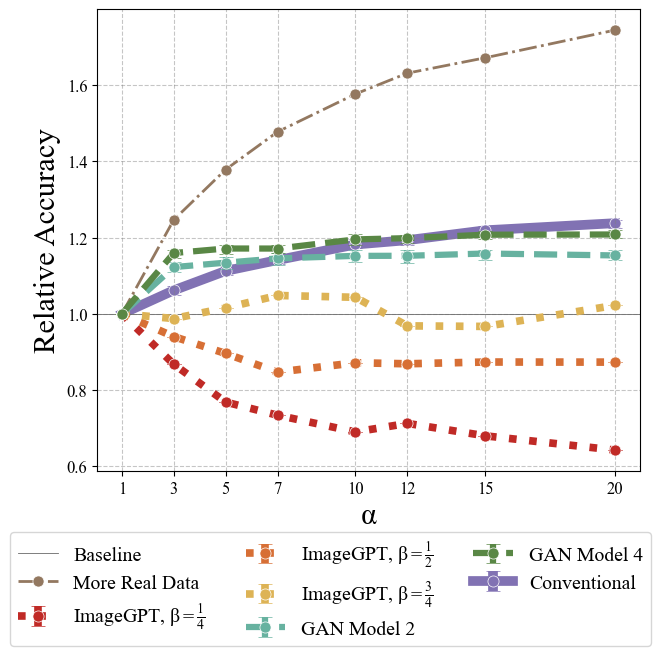

In [82]:
acc_all_models_plotname = "Images/acc_all_models.pdf"

def plot_scores_with_iqr(scores_df, label, color, lw=4.5, linestyle='-', zorder=2, alpha=1):
    median = scores_df.median()
    q1 = scores_df.quantile(0.25)
    q3 = scores_df.quantile(0.75)

    # Calculate error bars (IQR)
    error_lower = median - q1  # distance from median to Q1
    error_upper = q3 - median  # distance from median to Q3

    # Create a DataFrame for plotting
    error_df = pd.DataFrame({'alpha': alphas,'median': median,'error_lower': error_lower,'error_upper': error_upper,'label': label})

    plt.errorbar(error_df['alpha'], error_df['median'], zorder=zorder,
                 yerr=[error_lower, error_upper], linestyle=linestyle,
                 fmt='o', color=color, capsize=5, lw=lw, label=label, alpha=alpha,
                 markeredgecolor='white', markeredgewidth=0.5, markersize=8)

# Define column groupings, labels, and colors
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-8'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-8'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-8']]
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-9', 'small-11', 'small-14', 'small-19'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-9', 'med-11', 'med-14', 'med-19'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-9', 'large-11', 'large-14', 'large-19']]

labels = [r"ImageGPT, $\beta = \frac{1}{4}$", r"ImageGPT, $\beta = \frac{1}{2}$", r"ImageGPT, $\beta = \frac{3}{4}$"]

plt.figure(figsize=my_fig_size)

# Add horizontal line for the baseline
plot_baseline(label = 'Baseline')

# Plot iGPT data
for column_group, label, color in zip(column_groups, labels, imagegpt_palette):
    plot_scores_with_iqr(rel_score_df[column_group], label, color,linestyle=':', lw=5.5)

# Plot GAN data
_ = plot_scores_with_iqr(gan_2_scores_df, label='GAN Model 2', color=gan_palette[1],linestyle='--')
_ = plot_scores_with_iqr(gan_4_scores_df, label='GAN Model 4', color=gan_palette[0],linestyle='--')

# Plot conventional data
plot_scores_with_iqr(normalized_conv_df, label='Conventional', color=custom_palette[0], zorder=1, lw=7)

# Plot real-only
plt.plot(more_real_accs_df['alpha'], more_real_accs_df['real-only'], marker='o', 
         linestyle='-.', lw=2, color=custom_palette[-1], label="More Real Data",
         markeredgecolor='white', markeredgewidth=0.5, markersize=8)


# Customize plot
plt.xlabel("α", fontsize=label_size)
plt.ylabel("Relative Accuracy", fontsize=label_size)
plt.xticks(alphas, fontsize=tick_size)
plt.yticks(fontsize=tick_size)

# plt.ylim([0.66, 1.57])

if plot_titles:
    plt.title("Relative Accuracy for all SDGs", fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=legend_size*0.75, loc='lower center', ncol = 3, bbox_to_anchor=(0.43, -0.4))#, frameon=False)
plt.grid(True, **grid_params)

if save_plots:
    plt.savefig(acc_all_models_plotname, format="pdf", bbox_inches="tight")

plt.show()

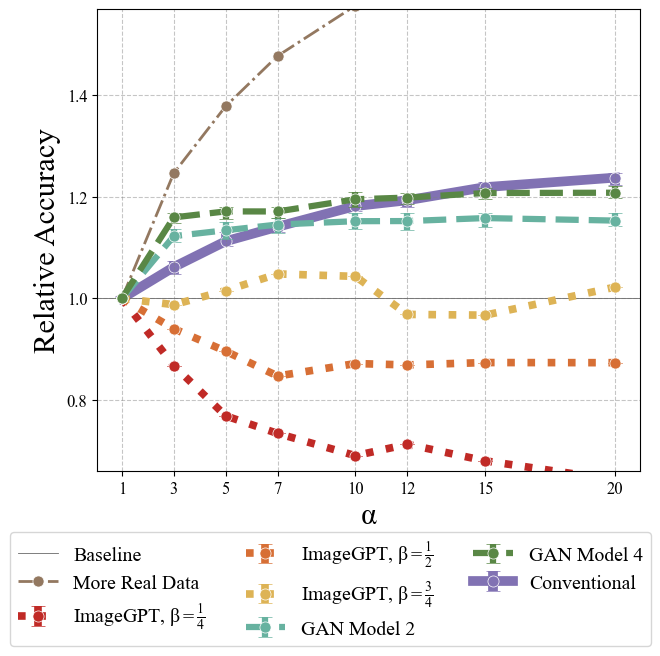

In [83]:
acc_all_models_plotname = "Images/acc_all_models.pdf"

def plot_scores_with_iqr(scores_df, label, color, lw=4.5, linestyle='-', zorder=2, alpha=1):
    median = scores_df.median()
    q1 = scores_df.quantile(0.25)
    q3 = scores_df.quantile(0.75)

    # Calculate error bars (IQR)
    error_lower = median - q1  # distance from median to Q1
    error_upper = q3 - median  # distance from median to Q3

    # Create a DataFrame for plotting
    error_df = pd.DataFrame({'alpha': alphas,'median': median,'error_lower': error_lower,'error_upper': error_upper,'label': label})

    plt.errorbar(error_df['alpha'], error_df['median'], zorder=zorder,
                 yerr=[error_lower, error_upper], linestyle=linestyle,
                 fmt='o', color=color, capsize=5, lw=lw, label=label, alpha=alpha,
                 markeredgecolor='white', markeredgewidth=0.5, markersize=8)

# Define column groupings, labels, and colors
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-8'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-8'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-8']]
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-9', 'small-11', 'small-14', 'small-19'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-9', 'med-11', 'med-14', 'med-19'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-9', 'large-11', 'large-14', 'large-19']]

labels = [r"ImageGPT, $\beta = \frac{1}{4}$", r"ImageGPT, $\beta = \frac{1}{2}$", r"ImageGPT, $\beta = \frac{3}{4}$"]

plt.figure(figsize=my_fig_size)

# Add horizontal line for the baseline
plot_baseline(label = 'Baseline')

# Plot iGPT data
for column_group, label, color in zip(column_groups, labels, imagegpt_palette):
    plot_scores_with_iqr(rel_score_df[column_group], label, color,linestyle=':', lw=5.5)

# Plot GAN data
_ = plot_scores_with_iqr(gan_2_scores_df, label='GAN Model 2', color=gan_palette[1],linestyle='--')
_ = plot_scores_with_iqr(gan_4_scores_df, label='GAN Model 4', color=gan_palette[0],linestyle='--')

# Plot conventional data
plot_scores_with_iqr(normalized_conv_df, label='Conventional', color=custom_palette[0], zorder=1, lw=7)

# Plot real-only
plt.plot(more_real_accs_df['alpha'], more_real_accs_df['real-only'], marker='o', 
         linestyle='-.', lw=2, color=custom_palette[-1], label="More Real Data",
         markeredgecolor='white', markeredgewidth=0.5, markersize=8)


# Customize plot
plt.xlabel("α", fontsize=label_size)
plt.ylabel("Relative Accuracy", fontsize=label_size)
plt.xticks(alphas, fontsize=tick_size)
plt.yticks(fontsize=tick_size)

plt.ylim([0.66, 1.57])
#plt.xlim([0.9, 9.1])

if plot_titles:
    plt.title("Relative Accuracy for all SDGs", fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=legend_size*0.75, loc='lower center', ncol = 3, bbox_to_anchor=(0.43, -0.4))#, frameon=False)
plt.grid(True, **grid_params)

if save_plots:
    plt.savefig(acc_all_models_plotname, format="pdf", bbox_inches="tight")

plt.show()

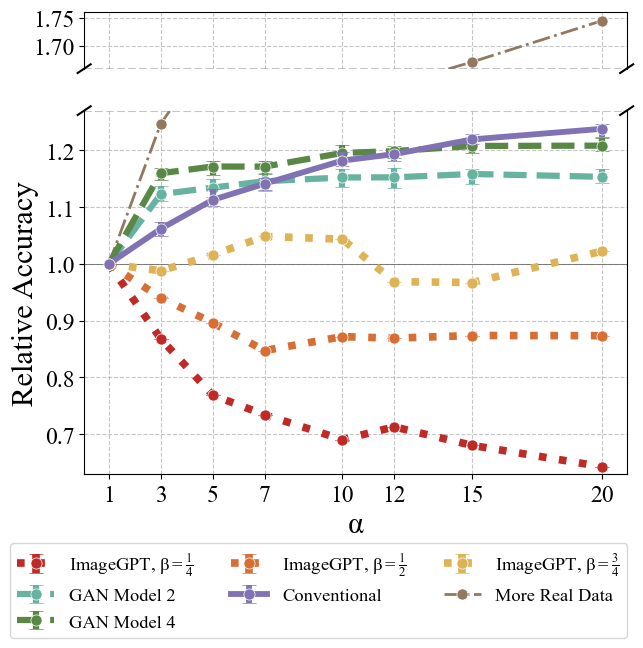

In [86]:
import matplotlib.gridspec as gridspec

# Function to plot scores with IQR
def plot_scores_with_iqr(scores_df, label, color, lw=4.5, linestyle='-', zorder=2, alpha=1, ax=None):
    if ax is None:
        ax = plt.gca()  # Get current axis if none is provided
    
    median = scores_df.median()
    q1 = scores_df.quantile(0.25)
    q3 = scores_df.quantile(0.75)

    # Calculate error bars (IQR)
    error_lower = median - q1  # distance from median to Q1
    error_upper = q3 - median  # distance from median to Q3

    # Create a DataFrame for plotting
    error_df = pd.DataFrame({'alpha': alphas, 'median': median, 'error_lower': error_lower, 'error_upper': error_upper, 'label': label})

    ax.errorbar(error_df['alpha'], error_df['median'], zorder=zorder,
                yerr=[error_lower, error_upper], linestyle=linestyle,
                fmt='o', color=color, capsize=5, lw=lw, label=label, alpha=alpha,
                markeredgecolor='white', markeredgewidth=0.5, markersize=8)

# Define the y-limits
ylim_upper = (1.66, 1.76)  # Upper range
ylim_lower = (0.63, 1.27)  # Lower range

# Calculate ranges
range_upper = ylim_upper[1] - ylim_upper[0]
range_lower = ylim_lower[1] - ylim_lower[0]

# Calculate relative heights for the subplots
total_range = range_upper + range_lower
height_upper = range_upper / total_range
height_lower = range_lower / total_range

# Create figure with GridSpec for proportional heights
fig = plt.figure(figsize=my_fig_size)
gs = gridspec.GridSpec(2, 1, height_ratios=[height_upper, height_lower])

ax1 = fig.add_subplot(gs[0])  # Upper axis
ax2 = fig.add_subplot(gs[1])  # Lower axis

# Set the y-limits
ax1.set_ylim(*ylim_upper)
ax2.set_ylim(*ylim_lower)

# Plot baseline on lower axis
plot_baseline(label='Baseline', ax=ax2)

# Plot iGPT data
labels = [r"ImageGPT, $\beta = \frac{1}{4}$", r"ImageGPT, $\beta = \frac{1}{2}$", r"ImageGPT, $\beta = \frac{3}{4}$"]
for column_group, label, color in zip(column_groups, labels, imagegpt_palette):
    plot_scores_with_iqr(rel_score_df[column_group], label, color, linestyle=':', lw=5.5, zorder=2, alpha=1, ax=ax2)

# Plot GAN data
plot_scores_with_iqr(gan_2_scores_df, label='GAN Model 2', color=gan_palette[1], linestyle='--', ax=ax2)
plot_scores_with_iqr(gan_4_scores_df, label='GAN Model 4', color=gan_palette[0], linestyle='--', ax=ax2)

# Plot conventional data
plot_scores_with_iqr(normalized_conv_df, label='Conventional', color=custom_palette[0], zorder=10, lw=4.2, ax=ax2)

# Plot real-only data
ax1.plot(more_real_accs_df['alpha'], more_real_accs_df['real-only'], marker='o', linestyle='-.', lw=2, color=custom_palette[-1], label="More Real Data", markeredgecolor='white', markeredgewidth=0.5, markersize=8)
ax2.plot(more_real_accs_df['alpha'], more_real_accs_df['real-only'], marker='o', linestyle='-.', lw=2, color=custom_palette[-1], label="More Real Data", markeredgecolor='white', markeredgewidth=0.5, markersize=8)

# Add diagonal lines to indicate the break
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
line_params = new_dict = {key: value for key, value in grid_params.items() if key != 'which'}
ax1.axhline(y=ylim_upper[0], **line_params)
ax2.axhline(y=ylim_lower[1], **line_params)
# Diagonal line adjustment for consistent slopes
d = 0.012  # Size of the diagonal lines in axis units
line_slope_adjustment = height_lower / height_upper  # Adjust slope based on height ratios
# Diagonal lines for the upper subplot
kwargs_upper = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d * line_slope_adjustment, +d * line_slope_adjustment), **kwargs_upper)
ax1.plot((1 - d, 1 + d), (-d * line_slope_adjustment, +d * line_slope_adjustment), **kwargs_upper)
# Diagonal lines for the lower subplot
kwargs_lower = dict(transform=ax2.transAxes, color='k', clip_on=False)
ax2.plot((-d, +d), (1 - d , 1 + d ), **kwargs_lower)
ax2.plot((1 - d, 1 + d), (1 - d , 1 + d ), **kwargs_lower)

# Add labels and legend
ax2.set_xlabel("α", fontsize=label_size)
ax2.set_ylabel("Relative Accuracy", fontsize=label_size)
ax2.set_xticks(alphas)
ax1.set_xticks(alphas)
ax1.set_xticklabels([])
ax1.tick_params(axis='x', which='both', length=0)
ax1.tick_params(axis='both', which='major', labelsize=tick_size)
ax2.tick_params(axis='both', which='major', labelsize=tick_size)

# Shared legend
handles, labels = ax2.get_legend_handles_labels()
handles, labels = ax2.get_legend_handles_labels()
new_labels = [labels[2], labels[5], labels[6], labels[3], labels[7], labels[4], labels[1]]
new_handles = [handles[2], handles[5], handles[6], handles[3], handles[7], handles[4], handles[1]]

# handles, labels = handles[1:], labels[1:]  # Remove the first entry (baseline in this case)
fig.legend(new_handles, new_labels, fontsize=legend_size * 0.7, loc='upper center', ncol=3, bbox_to_anchor=(0.46, 0.01))

# Add grid and title
ax1.grid(True, **grid_params)
ax2.grid(True, **grid_params)
if plot_titles:
    ax1.set_title("Relative Accuracy for all SDGs", fontsize=title_size)

# Save and show
if save_plots:
    plt.savefig(acc_all_models_plotname, format="pdf", bbox_inches="tight")

plt.show()

### If needed, only top performing models

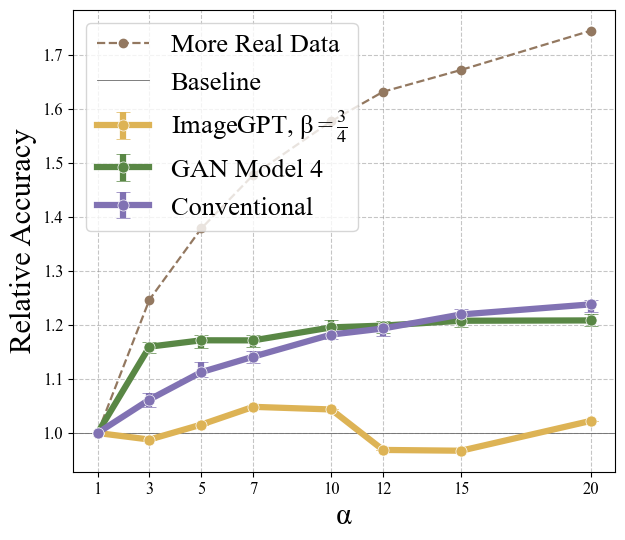

In [85]:
acc_best_models_only_plotname = "Images/acc_all_best_models.pdf"
    
# Define column groupings, labels, and colors
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-8'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-8'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-8']]
column_groups = [
    ['small-0', 'small-2', 'small-4', 'small-6', 'small-9', 'small-11', 'small-14', 'small-19'],
    ['med-0', 'med-2', 'med-4', 'med-6', 'med-9', 'med-11', 'med-14', 'med-19'],
    ['large-0', 'large-2', 'large-4', 'large-6', 'large-9', 'large-11', 'large-14', 'large-19']]

labels = [r"ImageGPT, $\beta = \frac{1}{4}$", r"ImageGPT, $\beta = \frac{1}{2}$", r"ImageGPT, $\beta = \frac{3}{4}$"]

plt.figure(figsize=my_fig_size)

# Plot iGPT data
for column_group, label, color in zip(column_groups, labels, imagegpt_palette):
    if label == r"ImageGPT, $\beta = \frac{3}{4}$":
        plot_scores_with_iqr(rel_score_df[column_group], label, color)

# Plot GAN data
# _ = plot_scores_with_iqr(gan_2_scores_df, label='GAN Model 2', color=gan_palette[1])
_ = plot_scores_with_iqr(gan_4_scores_df, label='GAN Model 4', color=gan_palette[0])

# Plot conventional data
plot_scores_with_iqr(normalized_conv_df, label='Conventional', color=custom_palette[0])

# Plot real-only
plt.plot(more_real_accs_df['alpha'], more_real_accs_df['real-only'], marker='o', linestyle='--', lw=1.6, color=custom_palette[-1], label="More Real Data")

# Add horizontal line for the baseline
# plt.axhline(y=1, ls="--", lw=3, color='gray', alpha=1, label='Baseline')
plot_baseline(label = 'Baseline')

# Customize plot
plt.xlabel("α", fontsize=label_size)
plt.ylabel("Relative Accuracy", fontsize=label_size)
plt.xticks(alphas, fontsize=tick_size)
plt.yticks(fontsize=tick_size)

if plot_titles:
    plt.title("Relative Accuracy for BEST CANDIDATE METHODS", fontsize=title_size)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.legend(fontsize=legend_size)
plt.grid(True, **grid_params)

if save_plots:
    plt.savefig(acc_best_models_only_plotname, format="pdf", bbox_inches="tight")

plt.show()
